# 1. Загружаем данные


In [40]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
from matplotlib import pyplot as plt
import sklearn as sk
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import scipy.stats as sps
# Deprecation warnings off
import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv("https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-11-03/ikea.csv", index_col=0).drop_duplicates()
df.head()

,item_id,name,category,price,old_price,sellable_online,link,other_colors,short_description,designer,depth,height,width
0,90420332,FREKVENS,Bar furniture,265.0,No old price,True,https://www.ikea.com/sa/en/p/frekvens-bar-tabl...,No,"Bar table, in/outdoor, 51x51 cm",Nicholai Wiig Hansen,NaN,99.0,51.0
1,368814,NORDVIKEN,Bar furniture,995.0,No old price,False,https://www.ikea.com/sa/en/p/nordviken-bar-tab...,No,"Bar table, 140x80 cm",Francis Cayouette,NaN,105.0,80.0
2,9333523,NORDVIKEN / NORDVIKEN,Bar furniture,2095.0,No old price,False,https://www.ikea.com/sa/en/p/nordviken-nordvik...,No,Bar table and 4 bar stools,Francis Cayouette,NaN,NaN,NaN
3,80155205,STIG,Bar furniture,69.0,No old price,True,https://www.ikea.com/sa/en/p/stig-bar-stool-wi...,Yes,"Bar stool with backrest, 74 cm",Henrik Preutz,50.0,100.0,60.0
4,30180504,NORBERG,Bar furniture,225.0,No old price,True,https://www.ikea.com/sa/en/p/norberg-wall-moun...,No,"Wall-mounted drop-leaf table, ...",Marcus Arvonen,60.0,43.0,74.0


# 2. EDA

In [41]:
#Оценим заполненность колонок значениями.
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3694 entries, 0 to 3693
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   item_id            3694 non-null   int64  
 1   name               3694 non-null   object 
 2   category           3694 non-null   object 
 3   price              3694 non-null   float64
 4   old_price          3694 non-null   object 
 5   sellable_online    3694 non-null   bool   
 6   link               3694 non-null   object 
 7   other_colors       3694 non-null   object 
 8   short_description  3694 non-null   object 
 9   designer           3694 non-null   object 
 10  depth              2231 non-null   float64
 11  height             2706 non-null   float64
 12  width              3105 non-null   float64
dtypes: bool(1), float64(4), int64(1), object(7)
memory usage: 378.8+ KB


Всего 3694 значения. Только габариты товаров имеют пустые значения.

In [42]:
print(df.isnull().sum())

item_id                 0
name                    0
category                0
price                   0
old_price               0
sellable_online         0
link                    0
other_colors            0
short_description       0
designer                0
depth                1463
height                988
width                 589
dtype: int64


Все характеристики имеют разброс уникальных значений, но категория и other_colors могут быть полезны в анализе
также возможно sellable_online

In [43]:
df.nunique()

item_id              2962
name                  607
category               17
price                 979
old_price             365
sellable_online         2
link                 2962
other_colors            2
short_description    1706
designer              381
depth                 114
height                193
width                 263
dtype: int64

проверим на наличие дубликатов, их нет

In [44]:
df.duplicated().sum()

0

проверим в процентном соотношении насколько большое кол-во не заполненных полей

In [45]:
for col in df.columns:
    print(f'{col} : {df[col].isna().sum() / df.shape[0] * 100: .2f}%')

item_id :  0.00%
name :  0.00%
category :  0.00%
price :  0.00%
old_price :  0.00%
sellable_online :  0.00%
link :  0.00%
other_colors :  0.00%
short_description :  0.00%
designer :  0.00%
depth :  39.60%
height :  26.75%
width :  15.94%


у нас только три поля имеют НаН не более 5% поэтому удалять просто их будет неправильно

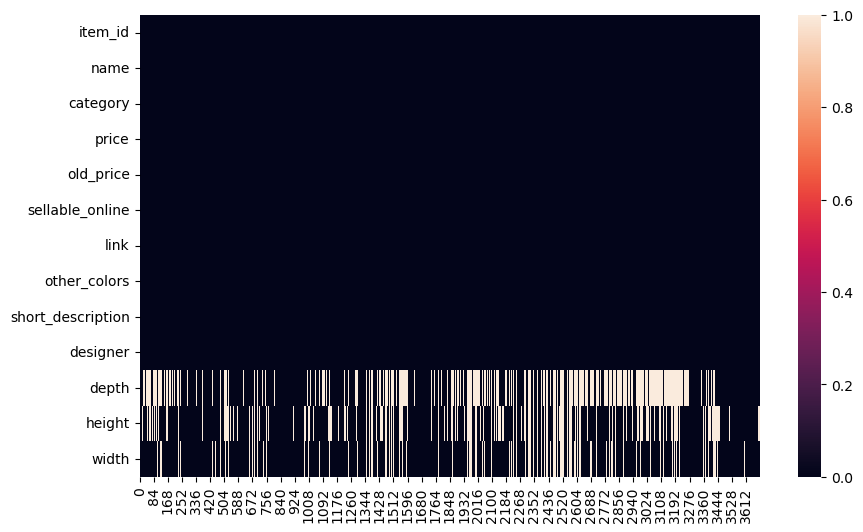

In [19]:
plt.figure(figsize=(10,6))
sns.heatmap(df.isna().transpose());

видим что есть записи в которых все 3 параметра имеют NaN значения

In [46]:
df['category'].value_counts()

Tables & desks                          612
Bookcases & shelving units              548
Chairs                                  481
Sofas & armchairs                       428
Cabinets & cupboards                    292
Wardrobes                               236
Outdoor furniture                       216
Beds                                    208
TV & media furniture                    190
Chests of drawers & drawer units        125
Children's furniture                    124
Nursery furniture                        97
Bar furniture                            47
Trolleys                                 28
Café furniture                           26
Sideboards, buffets & console tables     23
Room dividers                            13
Name: category, dtype: int64

видим что есть категории с очень небольшим кол-вом данных

поле old_price нуждается в некоторых изменениях:
удалить строку "SR" и изменить "No old price" на ту же цену, что и сейчас,
сделать её float

In [47]:
#  посмотрели какие значения имеет старая цена 
df.old_price.unique()

array(['No old price', 'SR 2,375', 'SR 295', 'SR 175', 'SR 995',
       'SR 1,385', 'SR 445', 'SR 925', 'SR 2,205', 'SR 895', 'SR 2,435',
       'SR 125', 'SR 1,595', 'SR 2,880', 'SR 940', 'SR 800', 'SR 1,995',
       'SR 3,245', 'SR 8,735', 'SR 2,310', 'SR 2,560', 'SR 3,760',
       'SR 3,130', 'SR 9,745', 'SR 1,885', 'SR 3,265', 'SR 50/4 pack',
       'SR 1,450', 'SR 250', 'SR 1,590', 'SR 2,360', 'SR 4,040',
       'SR 1,715', 'SR 2,100', 'SR 2,395', 'SR 1,250', 'SR 5,610',
       'SR 7,225', 'SR 2,795', 'SR 8,540', 'SR 1,950', 'SR 5,400',
       'SR 375', 'SR 5,045', 'SR 5,640', 'SR 3,665', 'SR 2,095',
       'SR 2,495', 'SR 9,430', 'SR 6,530', 'SR 138', 'SR 350', 'SR 1,023',
       'SR 437', 'SR 1,390', 'SR 50', 'SR 595', 'SR 275', 'SR 395',
       'SR 26', 'SR 695', 'SR 645', 'SR 649', 'SR 232', 'SR 750', 'SR 30',
       'SR 892', 'SR 10', 'SR 490', 'SR 4,185', 'SR 655', 'SR 27',
       'SR 455', 'SR 7', 'SR 657', 'SR 1,120', 'SR 237', 'SR 22',
       'SR 1,180', 'SR 15', 'SR 10/4

посмотрим поля сколько полей сожержат pack

In [48]:
df[df.old_price.str.find('pack') != -1]

,item_id,name,category,price,old_price,sellable_online,link,other_colors,short_description,designer,depth,height,width
155,60299691,BRYNILEN,Beds,30.0,SR 50/4 pack,True,https://www.ikea.com/sa/en/p/brynilen-leg-oak-...,No,"Leg, 10 cm",Ola Wihlborg,NaN,NaN,NaN
185,20299688,BRENNÅSEN,Beds,30.0,SR 50/4 pack,True,https://www.ikea.com/sa/en/p/brennasen-leg-bla...,No,"Leg, 10 cm",Ola Wihlborg,7.0,NaN,7.0
191,40299687,BURFJORD,Beds,40.0,SR 50/4 pack,True,https://www.ikea.com/sa/en/p/burfjord-leg-oak-...,No,"Leg, 10 cm",Ola Wihlborg,55.0,NaN,55.0
204,10309616,BÅTSFJORD,Beds,30.0,SR 50/4 pack,True,https://www.ikea.com/sa/en/p/batsfjord-leg-bir...,No,"Leg, 10 cm",Ehlén Johansson,NaN,NaN,NaN
222,70299695,BJORLI,Beds,40.0,SR 50/4 pack,True,https://www.ikea.com/sa/en/p/bjorli-leg-stainl...,Yes,"Leg, 10 cm",Ola Wihlborg,NaN,NaN,NaN
461,335885,SKÅDIS,Bookcases & shelving units,6.0,SR 10/4 pack,True,https://www.ikea.com/sa/en/p/skadis-connector-...,No,Connector for ALGOT,Eva Lilja Löwenhielm,2.0,4.0,5.0
2127,20386505,SJÄLLAND,Outdoor furniture,356.0,SR 445/2 pack,True,https://www.ikea.com/sa/en/p/sjaelland-table-t...,Yes,"Table top, outdoor, 85x72 cm",David Wahl,NaN,NaN,72.0
2315,20303751,NORSBORG,Sofas & armchairs,80.0,SR 100/4 pack,True,https://www.ikea.com/sa/en/p/norsborg-leg-birc...,No,Leg,Ehlén Johansson,NaN,18.0,NaN
2360,80382608,NORSBORG,Sofas & armchairs,140.0,SR 175/2 pack,True,https://www.ikea.com/sa/en/p/norsborg-cover-fo...,Yes,Cover for armrest,803.826.08 This cover's ability to resist abra...,NaN,NaN,NaN
2448,60382628,NORSBORG,Sofas & armchairs,80.0,SR 100/4 pack,True,https://www.ikea.com/sa/en/p/norsborg-leg-meta...,No,"Leg, 18 cm",603.826.28 These legs in nickel-plated steel g...,NaN,18.0,NaN


всего 10 строк содержат ```pack```, так как данная цена быстрее всего не за единицу, на 100% не знаем этого, то отсекаем эти поля также 

In [49]:
df = df[df.old_price.str.find('pack') == -1]
print(df.isnull().sum())

item_id                 0
name                    0
category                0
price                   0
old_price               0
sellable_online         0
link                    0
other_colors            0
short_description       0
designer                0
depth                1456
height                981
width                 583
dtype: int64


после удаления данных за упаковку, колв-от NaN изменилось но не значительно

In [50]:
def fix_old_price(df):
    '''modify old_price feature'''
    
    if df['old_price']  == 'No old price':
        return df['price']
    else:
        return float(str(df['old_price'])[3:].replace(',',''))


df['discounted'] = (df['old_price'] != 'No old price').astype(int)   
df['old_price_new'] = df.apply(fix_old_price, axis=1)
df[['price', 'old_price', 'discounted']].head()

,price,old_price,discounted
0,265.0,No old price,0
1,995.0,No old price,0
2,2095.0,No old price,0
3,69.0,No old price,0
4,225.0,No old price,0


мы поставили индикатор, discounted, который нам показывает в каких полях у нас не было информации по старой цене, если старая цена есть то будет 1, нет 0

In [51]:
df.category.unique()

array(['Bar furniture', 'Beds', 'Bookcases & shelving units',
       'Cabinets & cupboards', 'Café furniture', 'Chairs',
       'Chests of drawers & drawer units', "Children's furniture",
       'Nursery furniture', 'Outdoor furniture', 'Room dividers',
       'Sideboards, buffets & console tables', 'Sofas & armchairs',
       'Tables & desks', 'Trolleys', 'TV & media furniture', 'Wardrobes'],
      dtype=object)

проверим какие варианты в колонке other_colors

In [26]:
df.other_colors.unique()

array(['No', 'Yes'], dtype=object)

проверим какие значения в поле sellable_online

In [52]:
df.sellable_online.unique()

array([ True, False])

посмотрим товары в каких категориях имеют пропуски, возможно есть какие-то закономерности

In [53]:
df.groupby('category')[['depth', 'height', 'width']].apply(lambda x: x.notnull().sum())

,depth,height,width
category,,,
Bar furniture,27,35,37
Beds,81,157,183
Bookcases & shelving units,452,441,491
Cabinets & cupboards,237,230,256
Café furniture,14,22,21
Chairs,278,290,389
Chests of drawers & drawer units,121,123,125
Children's furniture,94,98,118
Nursery furniture,66,84,93


есть некоторые закономерности, в некоторых категориях, 
например, большинство Trolleys не имеют глубины


создадим копию в которой будут все данные, и там где есть NaN в т.ч.

In [54]:
df_1= df.copy()
df_1.head(2)

,item_id,name,category,price,old_price,sellable_online,link,other_colors,short_description,designer,depth,height,width,discounted,old_price_new
0,90420332,FREKVENS,Bar furniture,265.0,No old price,True,https://www.ikea.com/sa/en/p/frekvens-bar-tabl...,No,"Bar table, in/outdoor, 51x51 cm",Nicholai Wiig Hansen,NaN,99.0,51.0,0,265.0
1,368814,NORDVIKEN,Bar furniture,995.0,No old price,False,https://www.ikea.com/sa/en/p/nordviken-bar-tab...,No,"Bar table, 140x80 cm",Francis Cayouette,NaN,105.0,80.0,0,995.0


удалим строки в которых есть NaN

In [55]:
df = df.dropna() 
df.count()

item_id              1898
name                 1898
category             1898
price                1898
old_price            1898
sellable_online      1898
link                 1898
other_colors         1898
short_description    1898
designer             1898
depth                1898
height               1898
width                1898
discounted           1898
old_price_new        1898
dtype: int64

Удалим заведомо "бесполезные" колонки. Которые никак не влияют на стоимость

In [56]:

df = df.drop(['item_id', 'link'], axis=1)
print(df.columns)

df_1 = df_1.drop(['item_id', 'link'], axis=1)
print(df_1.columns)


Index(['name', 'category', 'price', 'old_price', 'sellable_online',
       'other_colors', 'short_description', 'designer', 'depth', 'height',
       'width', 'discounted', 'old_price_new'],
      dtype='object')
Index(['name', 'category', 'price', 'old_price', 'sellable_online',
       'other_colors', 'short_description', 'designer', 'depth', 'height',
       'width', 'discounted', 'old_price_new'],
      dtype='object')


In [57]:
df[df.category == "TV & media furniture"].describe()

,price,depth,height,width,discounted,old_price_new
count,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000
mean,1085.726316,40.610526,110.852632,168.768421,0.157895,1111.631579
std,894.729133,9.085053,71.531717,78.891718,0.366577,914.629062
min,35.000000,4.000000,10.000000,4.000000,0.000000,35.000000
25%,405.000000,40.000000,51.500000,120.000000,0.000000,420.000000
50%,990.000000,41.000000,74.000000,160.000000,0.000000,990.000000
75%,1627.500000,42.000000,190.500000,230.000000,0.000000,1627.500000
max,4260.000000,100.000000,251.000000,336.000000,1.000000,4260.000000


In [58]:
df[df.category == "Bar furniture"].head()

,name,category,price,old_price,sellable_online,other_colors,short_description,designer,depth,height,width,discounted,old_price_new
3,STIG,Bar furniture,69.0,No old price,True,Yes,"Bar stool with backrest, 74 cm",Henrik Preutz,50.0,100.0,60.0,0,69.0
4,NORBERG,Bar furniture,225.0,No old price,True,No,"Wall-mounted drop-leaf table, ...",Marcus Arvonen,60.0,43.0,74.0,0,225.0
5,INGOLF,Bar furniture,345.0,No old price,True,No,"Bar stool with backrest, 63 cm",Carina Bengs,45.0,91.0,40.0,0,345.0
6,FRANKLIN,Bar furniture,129.0,No old price,True,No,"Bar stool with backrest, foldable, ...",K Hagberg/M Hagberg,44.0,95.0,50.0,0,129.0
8,FRANKLIN,Bar furniture,129.0,No old price,True,No,"Bar stool with backrest, foldable, ...",K Hagberg/M Hagberg,44.0,95.0,50.0,0,129.0


In [59]:
df_bar_furniture = df[df.category == "Beds"]
df_bar_furniture.head()

,name,category,price,old_price,sellable_online,other_colors,short_description,designer,depth,height,width,discounted,old_price_new
48,BRIMNES,Beds,895.0,SR 925,True,No,"Bed frame w storage and headboard, ...",IKEA of Sweden/K Hagberg/M Hagberg,54.0,110.0,96.0,1,925.0
50,PLATSA,Beds,2111.0,"SR 2,205",True,No,"Bed frame with 4 drawers, 140...",Ola Wihlborg/IKEA of Sweden,40.0,43.0,140.0,1,2205.0
51,VATTVIKEN,Beds,995.0,No old price,True,No,Armchair-bed,504.689.53 Small and easy-to-place chair-bed w...,83.0,86.0,92.0,0,995.0
61,BRIMNES,Beds,575.0,No old price,True,No,"Bed frame with storage, 90x20...",K Hagberg/M Hagberg,54.0,47.0,96.0,0,575.0
67,MALM,Beds,920.0,No old price,True,Yes,"Bed frame, high, w 2 storage boxes, ...",IKEA of Sweden/Eva Lilja Löwenhielm,59.0,15.0,196.0,0,920.0


посмотрим на распределение цен по различным категориям

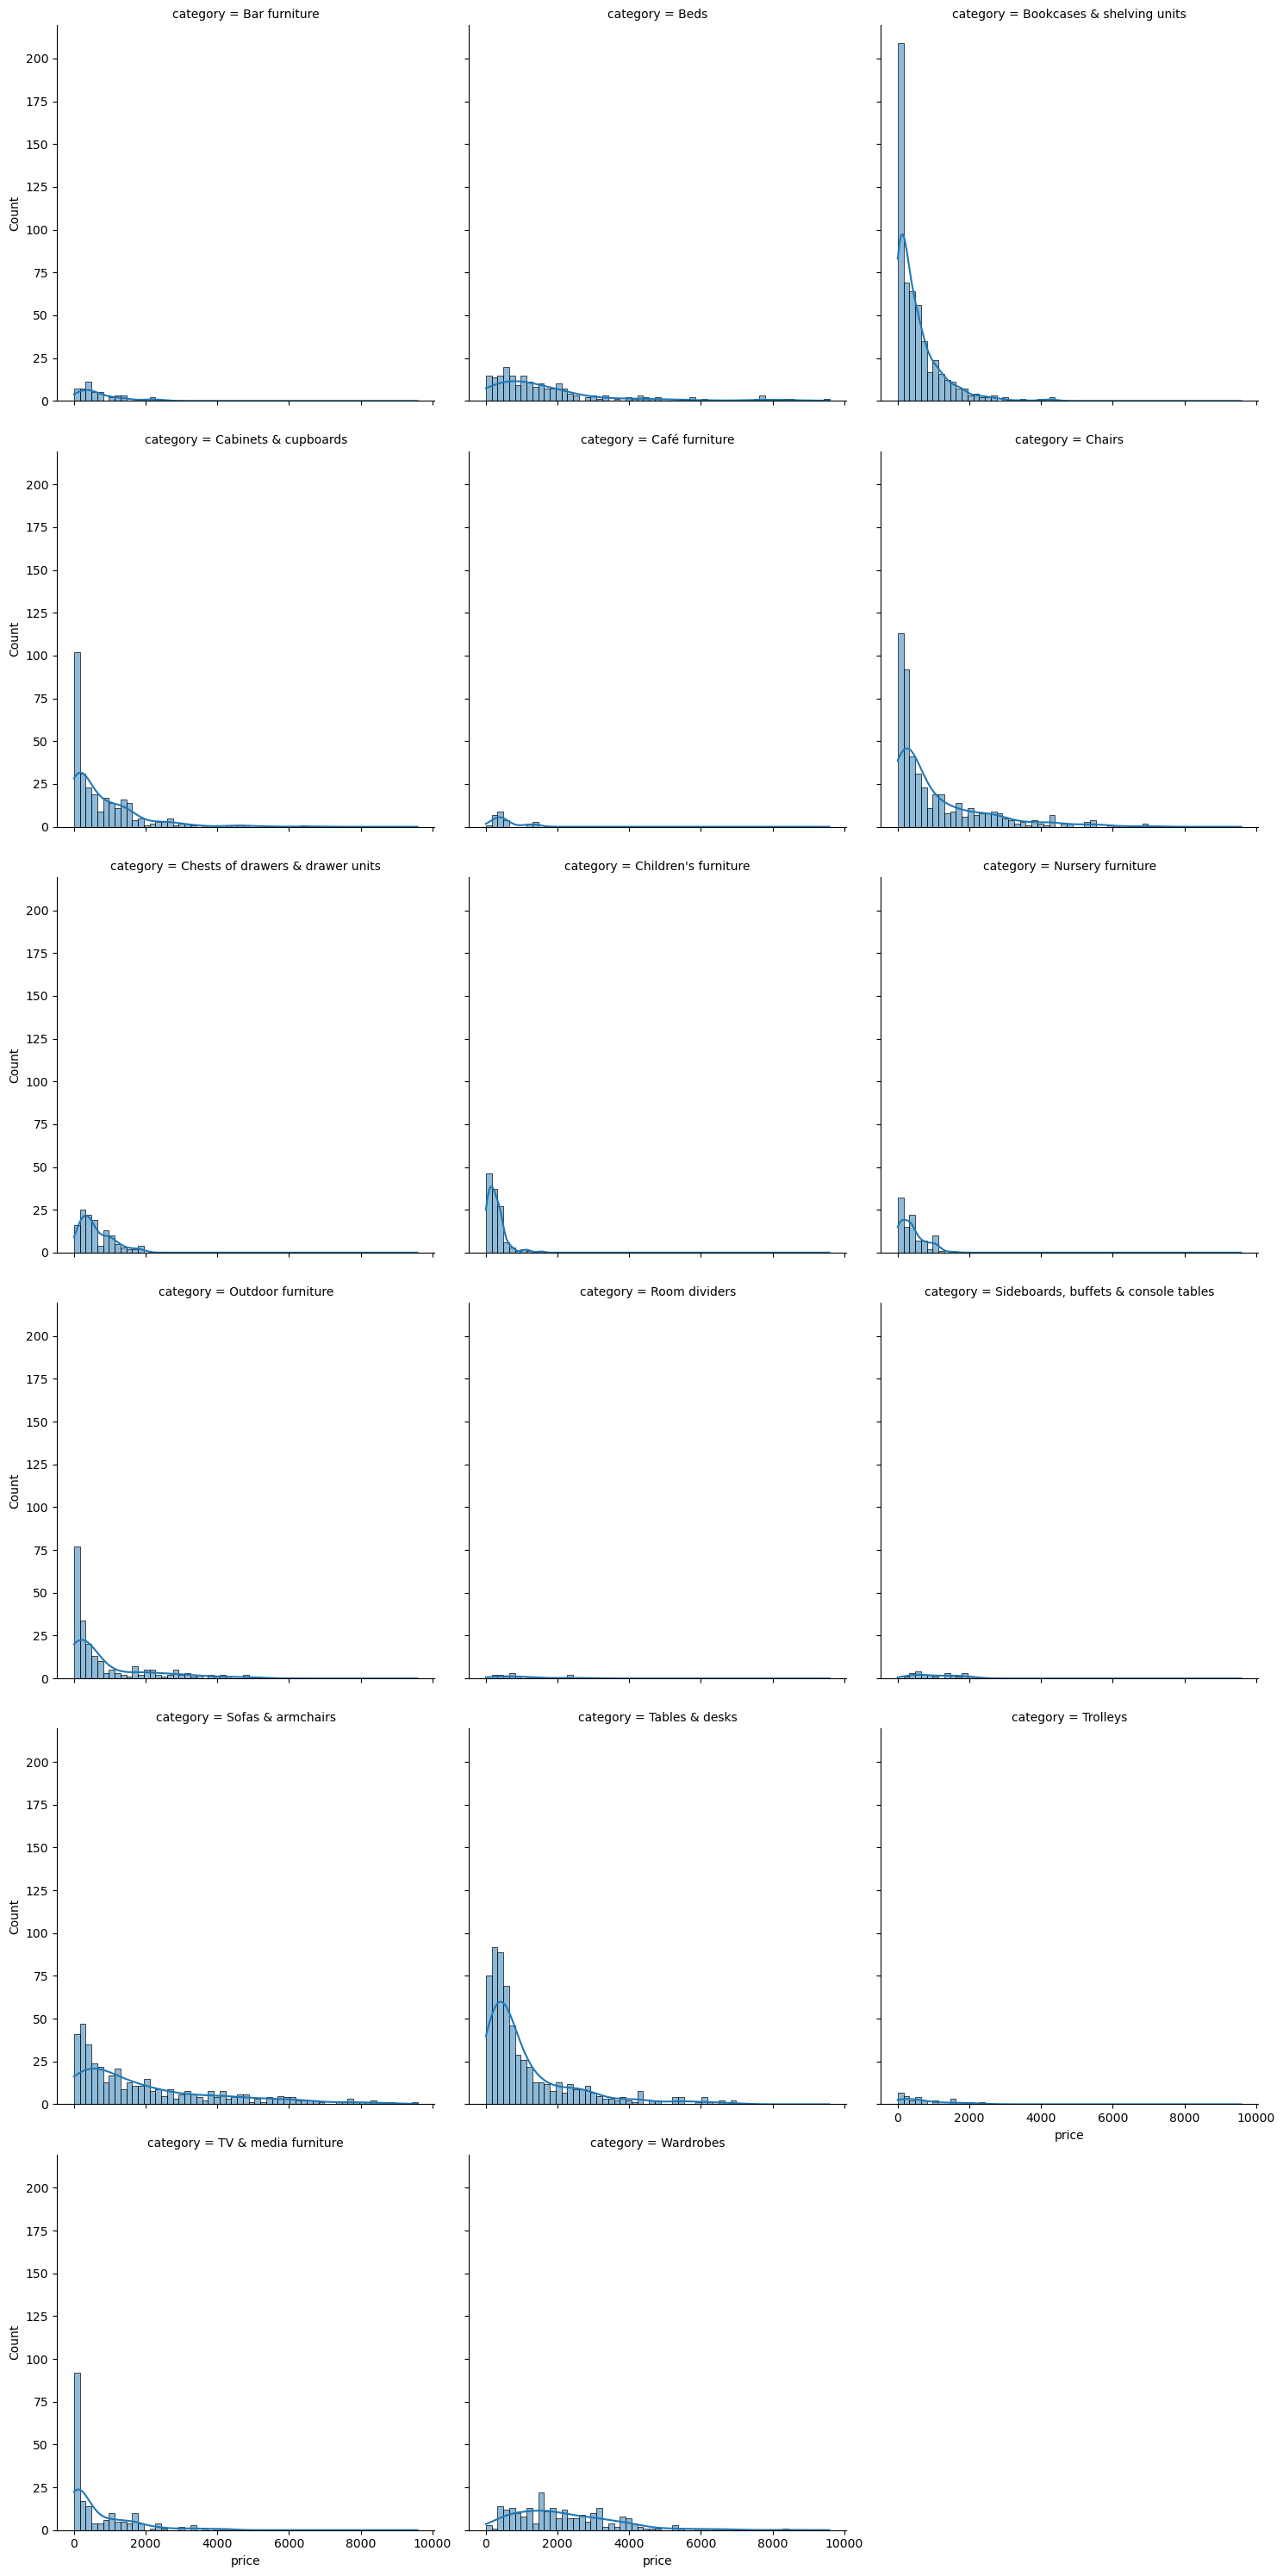

In [60]:
sns.displot(x='price',
            # binwidth = 1,
            kde=True, 
            col='category',
            col_wrap=3,
            data=df_1);

plt.show()

 основном распределение по категориям похоже на логнормальное
 

посмотрим на сравнение распределений текущей и старой цен


распределения чем-то похожи

Bar furniture


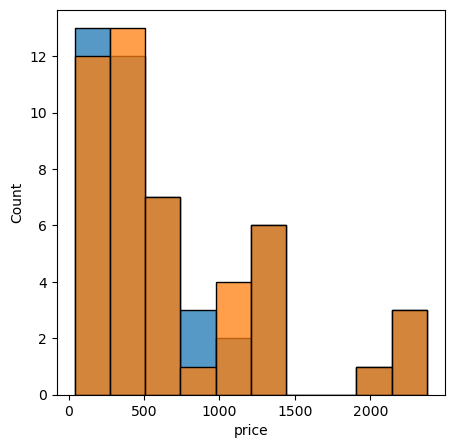

Beds


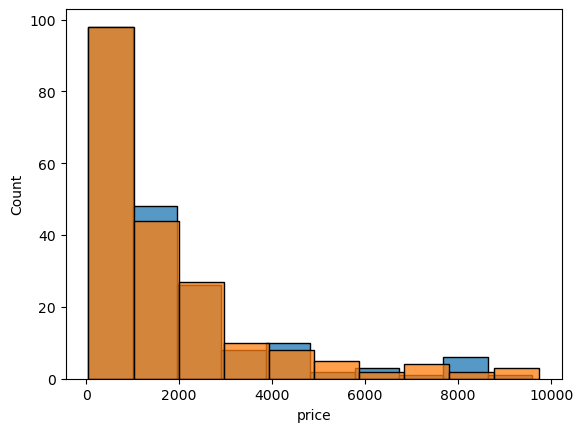

Bookcases & shelving units


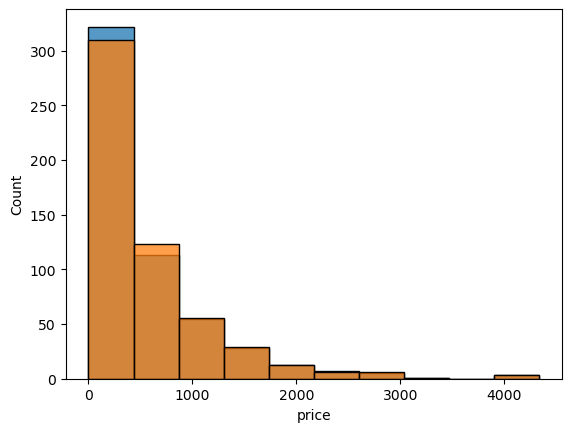

Cabinets & cupboards


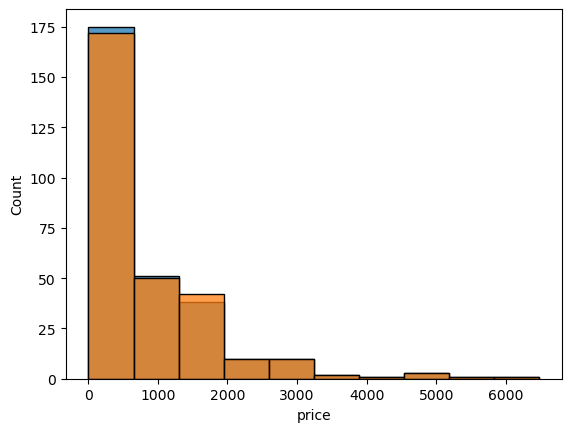

Café furniture


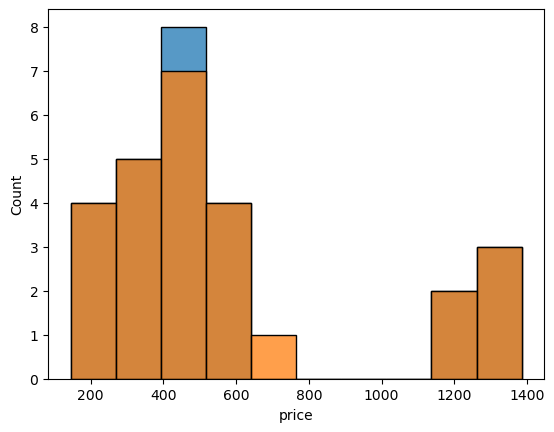

Chairs


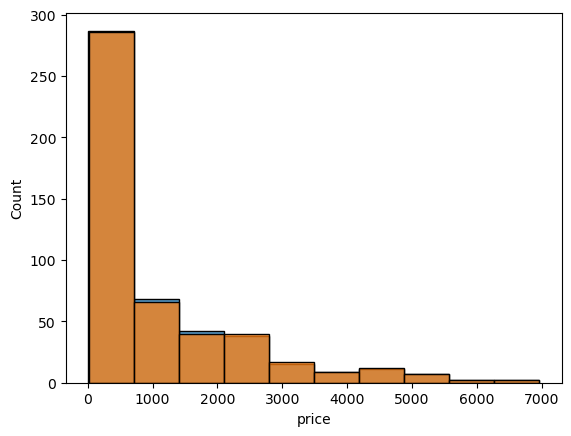

Chests of drawers & drawer units


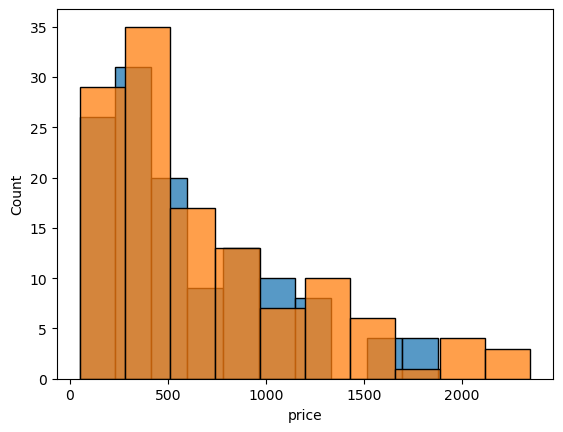

Children's furniture


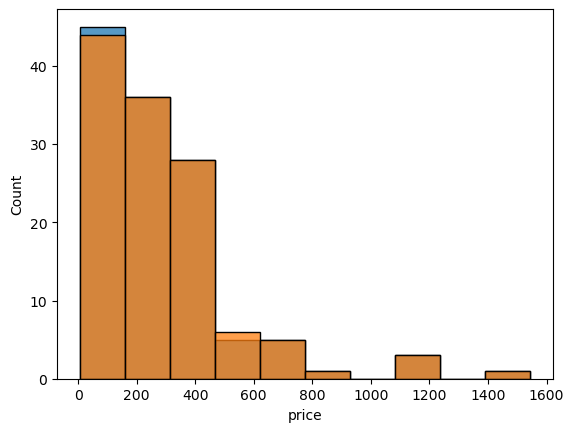

Nursery furniture


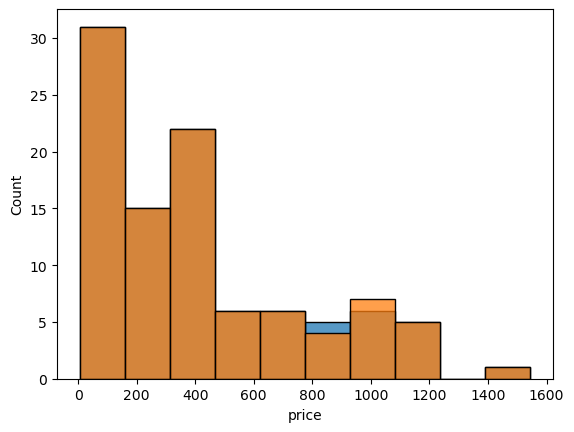

Outdoor furniture


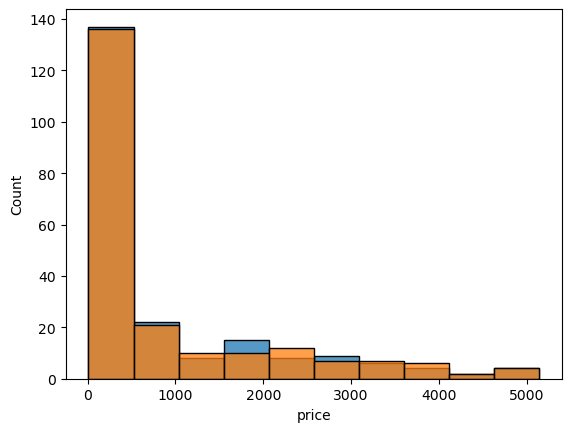

Room dividers


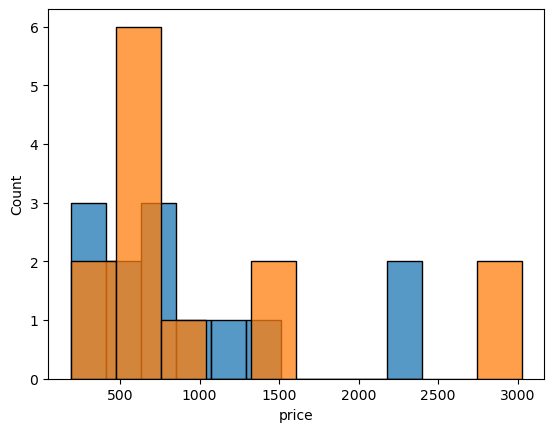

Sideboards, buffets & console tables


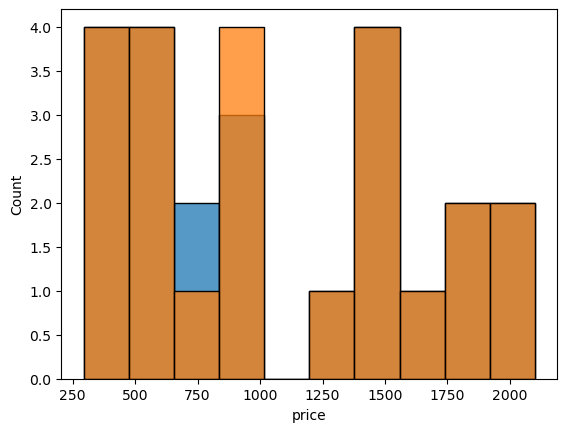

Sofas & armchairs


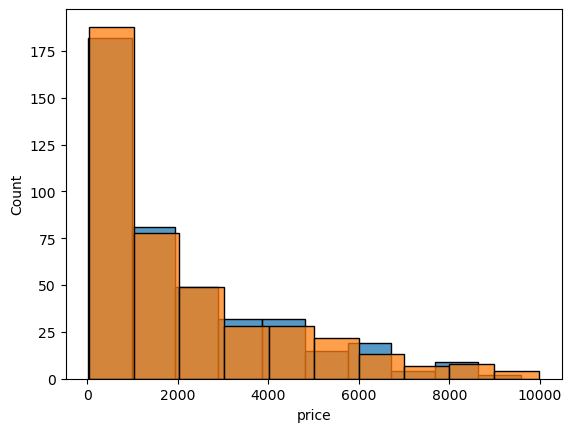

Tables & desks


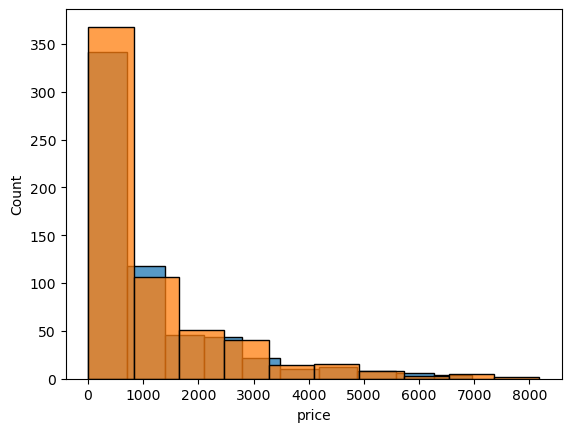

Trolleys


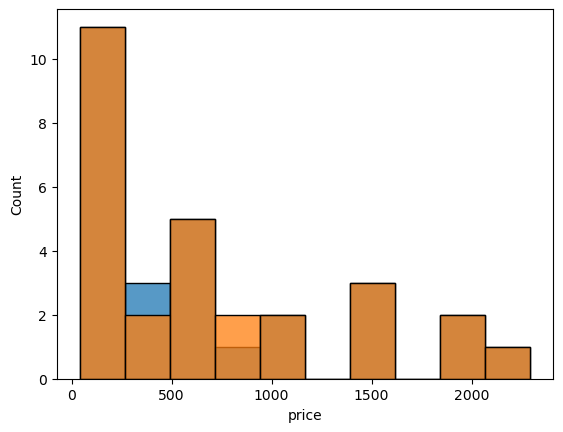

TV & media furniture


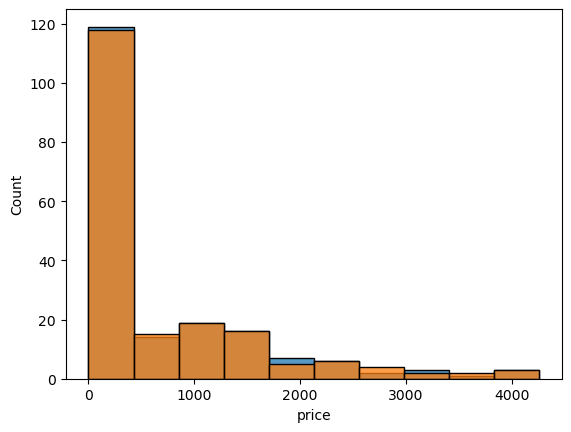

Wardrobes


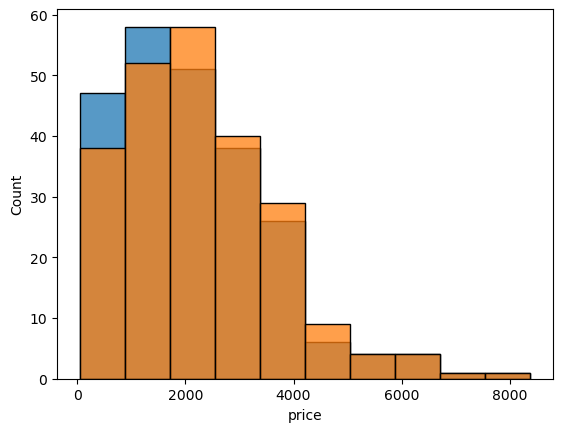

In [61]:
plt.figure(figsize=[5, 5])
for category in df_1.category.unique():
    print(category)
    sns.histplot(df_1[df_1.category == category].price,bins=10)
    sns.histplot(df_1[df_1.category == category].old_price_new,bins=10)
    plt.show()


посмотрим не в разрезе категорий, но и в общем 

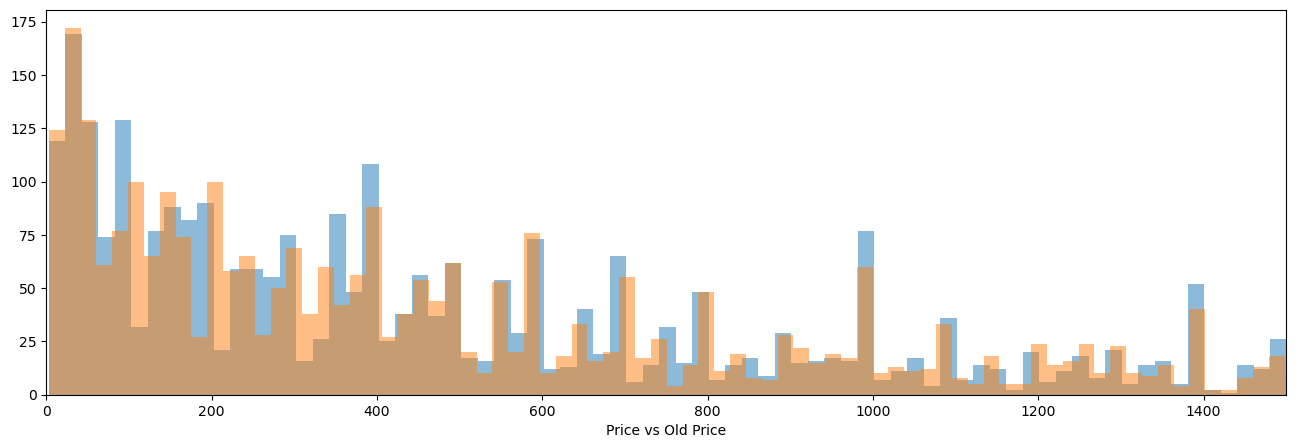

In [62]:
plt.figure(figsize=[16, 5])
plt.hist(data=df_1, x='old_price_new',bins=500, alpha=0.5)
plt.hist(data=df_1, x='price',bins=500, alpha=0.5)

plt.xlim(0,1500)

plt.xlabel('Price vs Old Price');

распределение старой и новой цен аналогично
также есть явные пики цен на каждые 100

графа sellable_online, в основном имеет значение TRUE и не влияет существенно на цену, можем ее не брать в расчет при проведении анализа

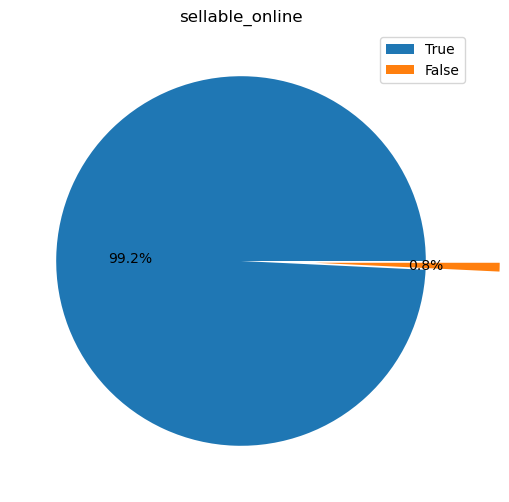

In [65]:
plt.figure(figsize=[6, 6])
plt.pie(df_1['sellable_online'].value_counts(), explode=(0, 0.4), autopct='%1.1f%%');
plt.legend(df_1['sellable_online'].unique())
plt.title('sellable_online')
plt.show()

почти равное кол-во позиций с и без других цветов, возможно влияние цвета на цену

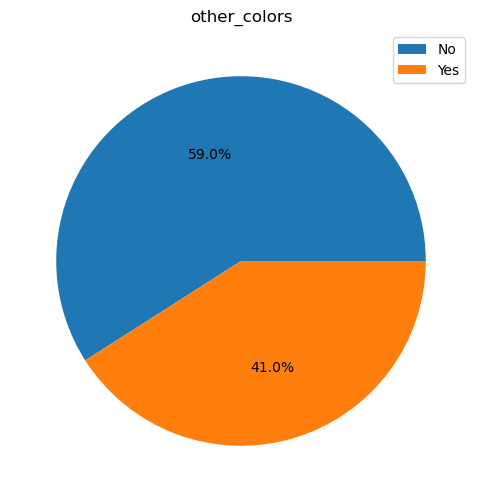

In [66]:
plt.figure(figsize=[6, 6])
plt.pie(df_1['other_colors'].value_counts(), explode=(0, 0), autopct='%1.1f%%');
plt.legend(df_1['other_colors'].unique())
plt.title('other_colors')
plt.show()

товаров со старой ценой у нас только 19%

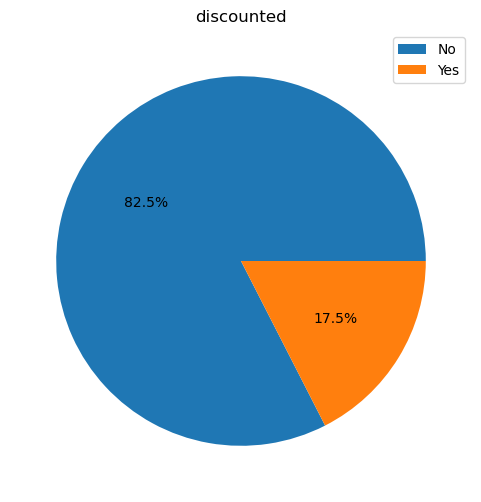

In [67]:
plt.figure(figsize=[6, 6])
plt.pie(df_1['discounted'].value_counts(), explode=(0, 0), autopct='%1.1f%%')
plt.legend(df_1['other_colors'].unique());
plt.title('discounted')
plt.show()

сделаем исследование цена текущая против старой цены

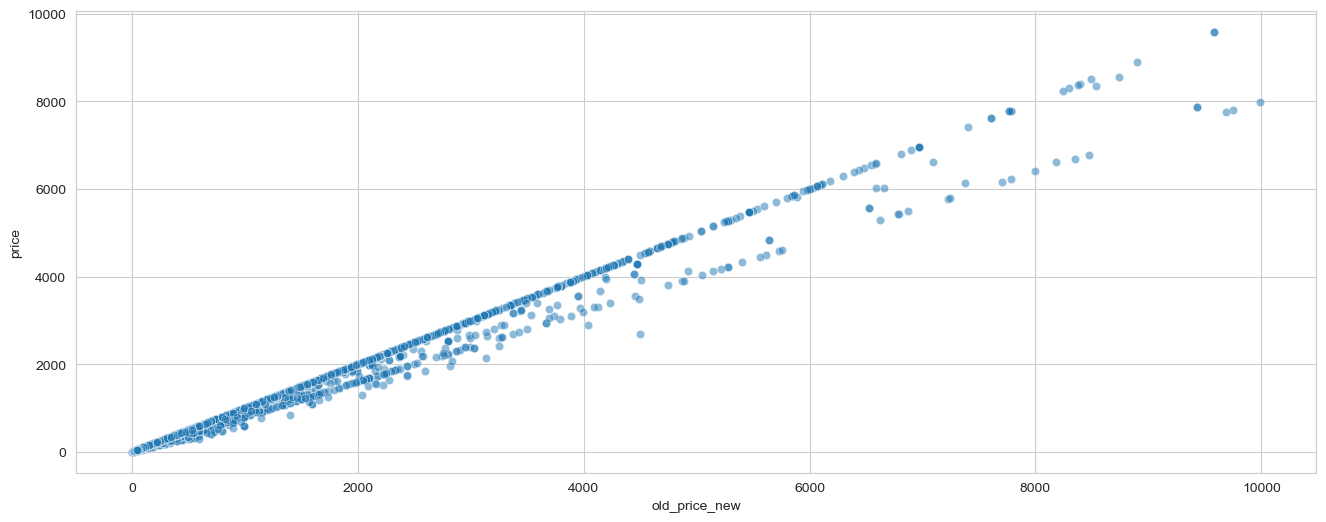

In [ ]:
plt.figure(figsize=[16, 6])
sns.scatterplot(data=df_1, x="old_price_new", y="price", alpha=0.5);
plt.show()

интересная зависимость между старой и текущей ценой, здесь мы видим линейное увеличение величины скидок тем больше, чем больше растет цена
возможно, мы сможем увидеть больше, если посмотрим на связь между ценами и размером скидки

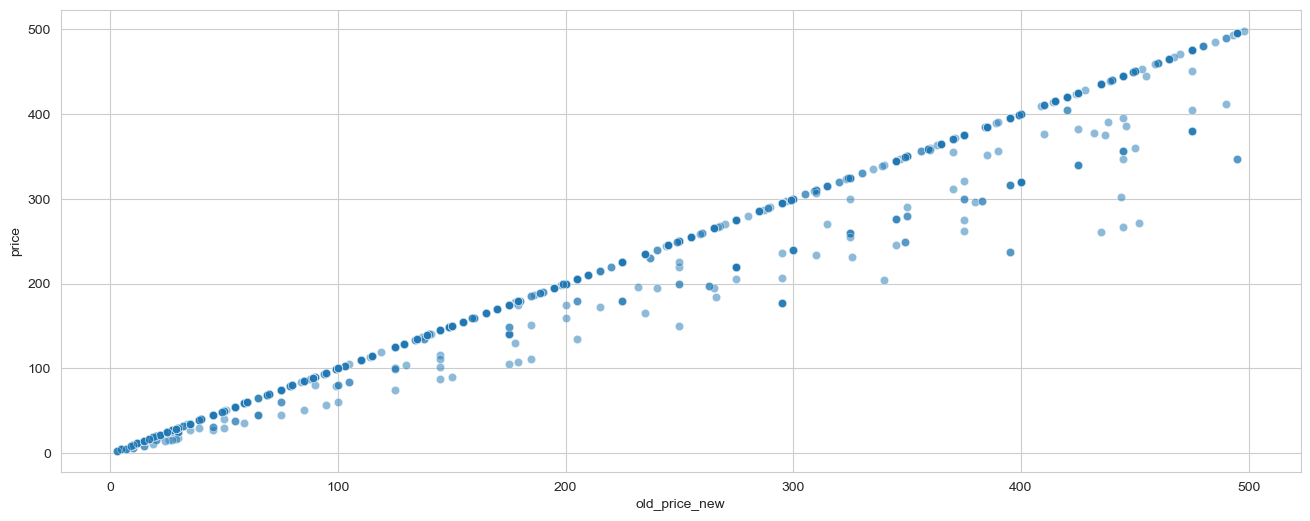

In [ ]:
plt.figure(figsize=[16, 6])
sns.scatterplot(data=df_1[df_1['old_price_new'] < 500], x="old_price_new", y="price", alpha=0.5)
plt.show()

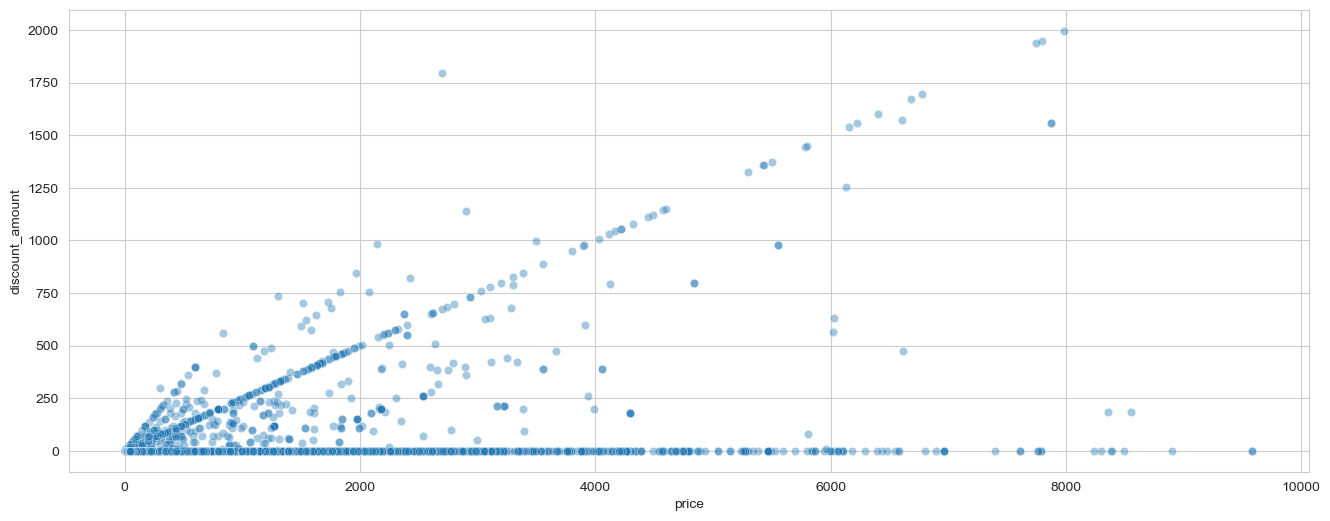

In [ ]:
plt.figure(figsize=[16, 6])
df_1['discount_amount'] = df_1['old_price_new'] - df_1['price']
sns.scatterplot(data=df_1, x="price", y="discount_amount", alpha=0.4)
plt.show()

из этой визуализации мы обнаружили:
- большинство товаров не имеют скидок (т.е. у них нет старой цены или же цена не имела изменений)
- для низких цен есть две линейные связи, одна из которых имеет общую линию с высокими ценами, а другая ограничена только низкими ценами


In [ ]:
def draw (x_draw, y_draw, color_draw, ax_1, func):
    importance_0 = func(x_draw, y_draw)
    feature_importances = pd.Series(importance_0, x_draw.columns)
    feature_importances.plot(kind='barh', color=color_draw, ax=ax_1)


посмотрим зависимость переметров изделия от цены. 
исследования сделаем на базе где были удалены NaN

[0 1 3]
[[ 100.   60.   69.]
 [  43.   74.  225.]
 [  91.   40.  345.]
 ...
 [ 236.  100. 2100.]
 [ 236.  150. 3985.]
 [ 236.  200. 2045.]]


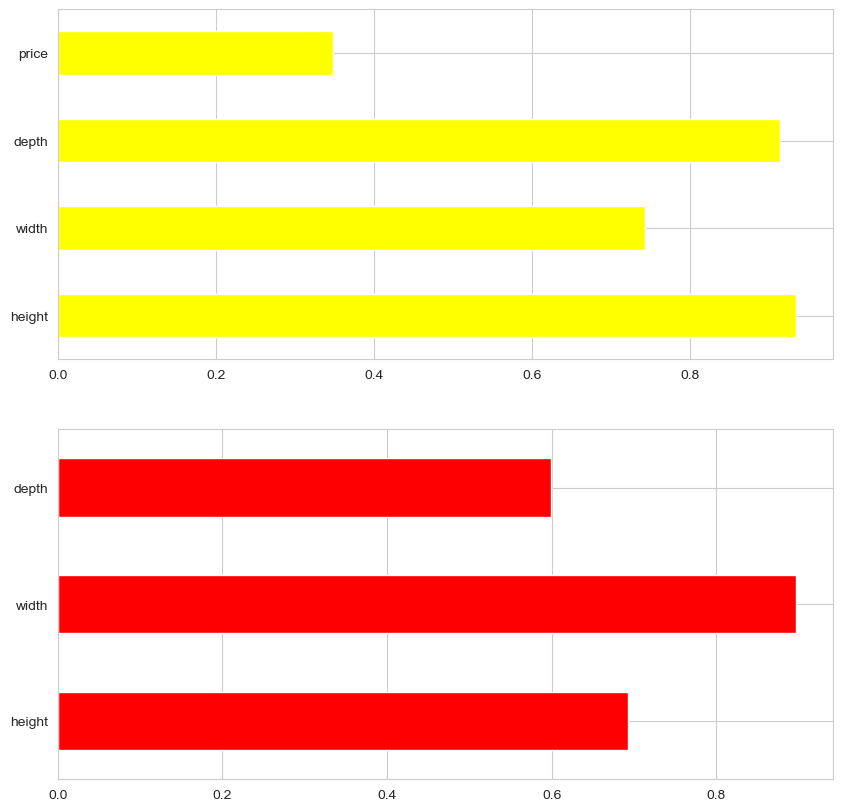

In [ ]:
from sklearn.feature_selection import mutual_info_classif,mutual_info_regression
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest

_, (ax1,ax2) = plt.subplots(2,1,figsize=(10,10))

#df_X = df.drop(['price'], axis=1)
df_X = df[['height', 'width', 'depth', 'price']]
df_y = df['category']
draw(df_X,df_y, 'yellow', ax1, mutual_info_classif)

df_X_1 = df[['height', 'width', 'depth']]
df_y_1 = df['price']
draw(df_X_1, df_y_1, 'red', ax2, mutual_info_regression)

chi2_features = SelectKBest(chi2, k = 3)
X_kbest_features = chi2_features.fit(df_X, df_y)
print(X_kbest_features.get_support(indices=True))

transformed_X = chi2_features.transform(df_X)
print(transformed_X)

plt.show()

Регуляризация состоит в добавлении штрафа (penalty) к различным параметрам модели во избежание чрезмерной подгонки. При регуляризации линейной модели штраф применяется к коэффициентам, умножающим каждый из предикторов. Lasso-регуляризация обладает свойством, позволяющим уменьшить некоторые коэффициенты до нуля. Следовательно, такие “фичи” можно будет просто удалить из модели.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel

# Устанавливаем наш параметр регуляризации C=1, чем меньше значение, тем сильнее регуляризация.
logistic = LogisticRegression(C=1, penalty="l1", 
							  solver='liblinear', 
							  random_state=7).fit(df_X, df_y)
# Где X, y - входные и выходные данные соответственно.
model = SelectFromModel(logistic, prefit=True, 
						max_features=3,
						threshold='0.8*mean')

X_new = model.transform(df_X)
print(model.get_support(indices=True),X_new)

[0 1 2] [[100.  60.  50.]
 [ 43.  74.  60.]
 [ 91.  40.  45.]
 ...
 [236. 100.  60.]
 [236. 150.  66.]
 [236. 200.  66.]]


Категория зависит наибольшим образом от ```height```, ```depth```, ```price```


In [ ]:
#from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

selector = SelectKBest(f_regression, k=2).fit(df_X_1, df_y_1)
data = selector.transform(df_X_1)
print(selector.scores_, selector.get_support(indices=True), data,sep='\n')

[ 151.54104642 2750.5502897  1211.3472869 ]
[1 2]
[[ 60.  50.]
 [ 74.  60.]
 [ 40.  45.]
 ...
 [100.  60.]
 [150.  66.]
 [200.  66.]]


цена наибольшим образом зависит от 'width', 'depth'
посмотрим что у нас происходит внутри категорий

In [ ]:
for category in df.category.unique():
    print(category)
    df_X_1 = df[df.category==category][['height', 'width', 'depth']]
    df_y_1 = df[df.category==category]['price']
    selector = SelectKBest(f_regression, k=2).fit(df_X_1, df_y_1)
    data = selector.transform(df_X_1)
    print(selector.scores_, selector.get_support(indices=True), data,sep='\n')

Bar furniture
[0.2741662  6.02949955 0.12445389]
[0 1]
[[100.  60.]
 [ 43.  74.]
 [ 91.  40.]
 [ 95.  50.]
 [ 95.  50.]
 [103.  52.]
 [102.  40.]
 [103.  46.]
 [104.  43.]
 [114.  43.]
 [102.  40.]
 [ 84.  38.]
 [103.  52.]
 [ 63.  44.]
 [ 84.  38.]
 [114.  43.]
 [114.  43.]
 [102.  40.]
 [102.  40.]
 [100.  42.]
 [101.  40.]
 [ 90.  48.]
 [100.  50.]
 [ 63.  44.]]
Beds
[ 26.33269075 129.06306029  53.66078314]
[1 2]
[[ 96.  54.]
 [140.  40.]
 [ 92.  83.]
 [ 96.  54.]
 [196.  59.]
 [146.  54.]
 [ 89.  70.]
 [105.  59.]
 [143.  40.]
 [128.  85.]
 [240.  51.]
 [153.  64.]
 [ 92.  55.]
 [ 89.  70.]
 [ 95.  57.]
 [200.  97.]
 [ 96.  57.]
 [149.  72.]
 [146.  28.]
 [ 89.  70.]
 [140.  51.]
 [113.  93.]
 [ 95.  45.]
 [140.  40.]
 [140.  40.]
 [140.  40.]
 [ 86.  53.]
 [153.  64.]
 [ 96.  53.]
 [142. 100.]
 [141.  40.]
 [141.  40.]
 [ 80. 100.]
 [ 96.  28.]
 [141.  40.]
 [225.  86.]
 [230.  99.]
 [141.  40.]
 [196.  98.]
 [252. 164.]
 [ 86.  53.]
 [ 62.  53.]
 [212.  78.]
 [140.  40.]
 [200.  

внутри категорий ситация получилась другая

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler() 
df_X_1_scaled = pd.DataFrame(scaler.fit_transform(df_X_1), columns = df_X_1.columns)
df_X_1_scaled.head()

,height,width,depth
0,0.564315,0.093085,0.114286
1,0.668050,0.281915,0.131429
2,0.609959,0.095745,0.085714
3,0.668050,0.281915,0.142857
4,0.585062,0.308511,0.040000


In [ ]:
from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold(0.02)
selector.fit(df_X_1_scaled)
df_X_1_scaled.columns[selector.get_support()]

Index(['height', 'width'], dtype='object')

In [ ]:
selector.variances_

array([0.02360524, 0.03071397, 0.0064849 ])

In [ ]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=3)
model.fit(df_X_1, df_y_1)
importances = model.feature_importances_
print(importances)

[0.4629523  0.39752091 0.13952679]


In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=4)
model.fit(df_X, df_y)
importances = model.feature_importances_
print(importances)

[0.27126957 0.20522882 0.29774366 0.22575795]


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1898 entries, 3 to 3688
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               1898 non-null   object 
 1   category           1898 non-null   object 
 2   price              1898 non-null   float64
 3   old_price          1898 non-null   object 
 4   sellable_online    1898 non-null   bool   
 5   other_colors       1898 non-null   object 
 6   short_description  1898 non-null   object 
 7   designer           1898 non-null   object 
 8   depth              1898 non-null   float64
 9   height             1898 non-null   float64
 10  width              1898 non-null   float64
 11  discounted         1898 non-null   int32  
 12  old_price_new      1898 non-null   float64
dtypes: bool(1), float64(5), int32(1), object(6)
memory usage: 187.2+ KB


Построим гистограммы для некоторых параметров

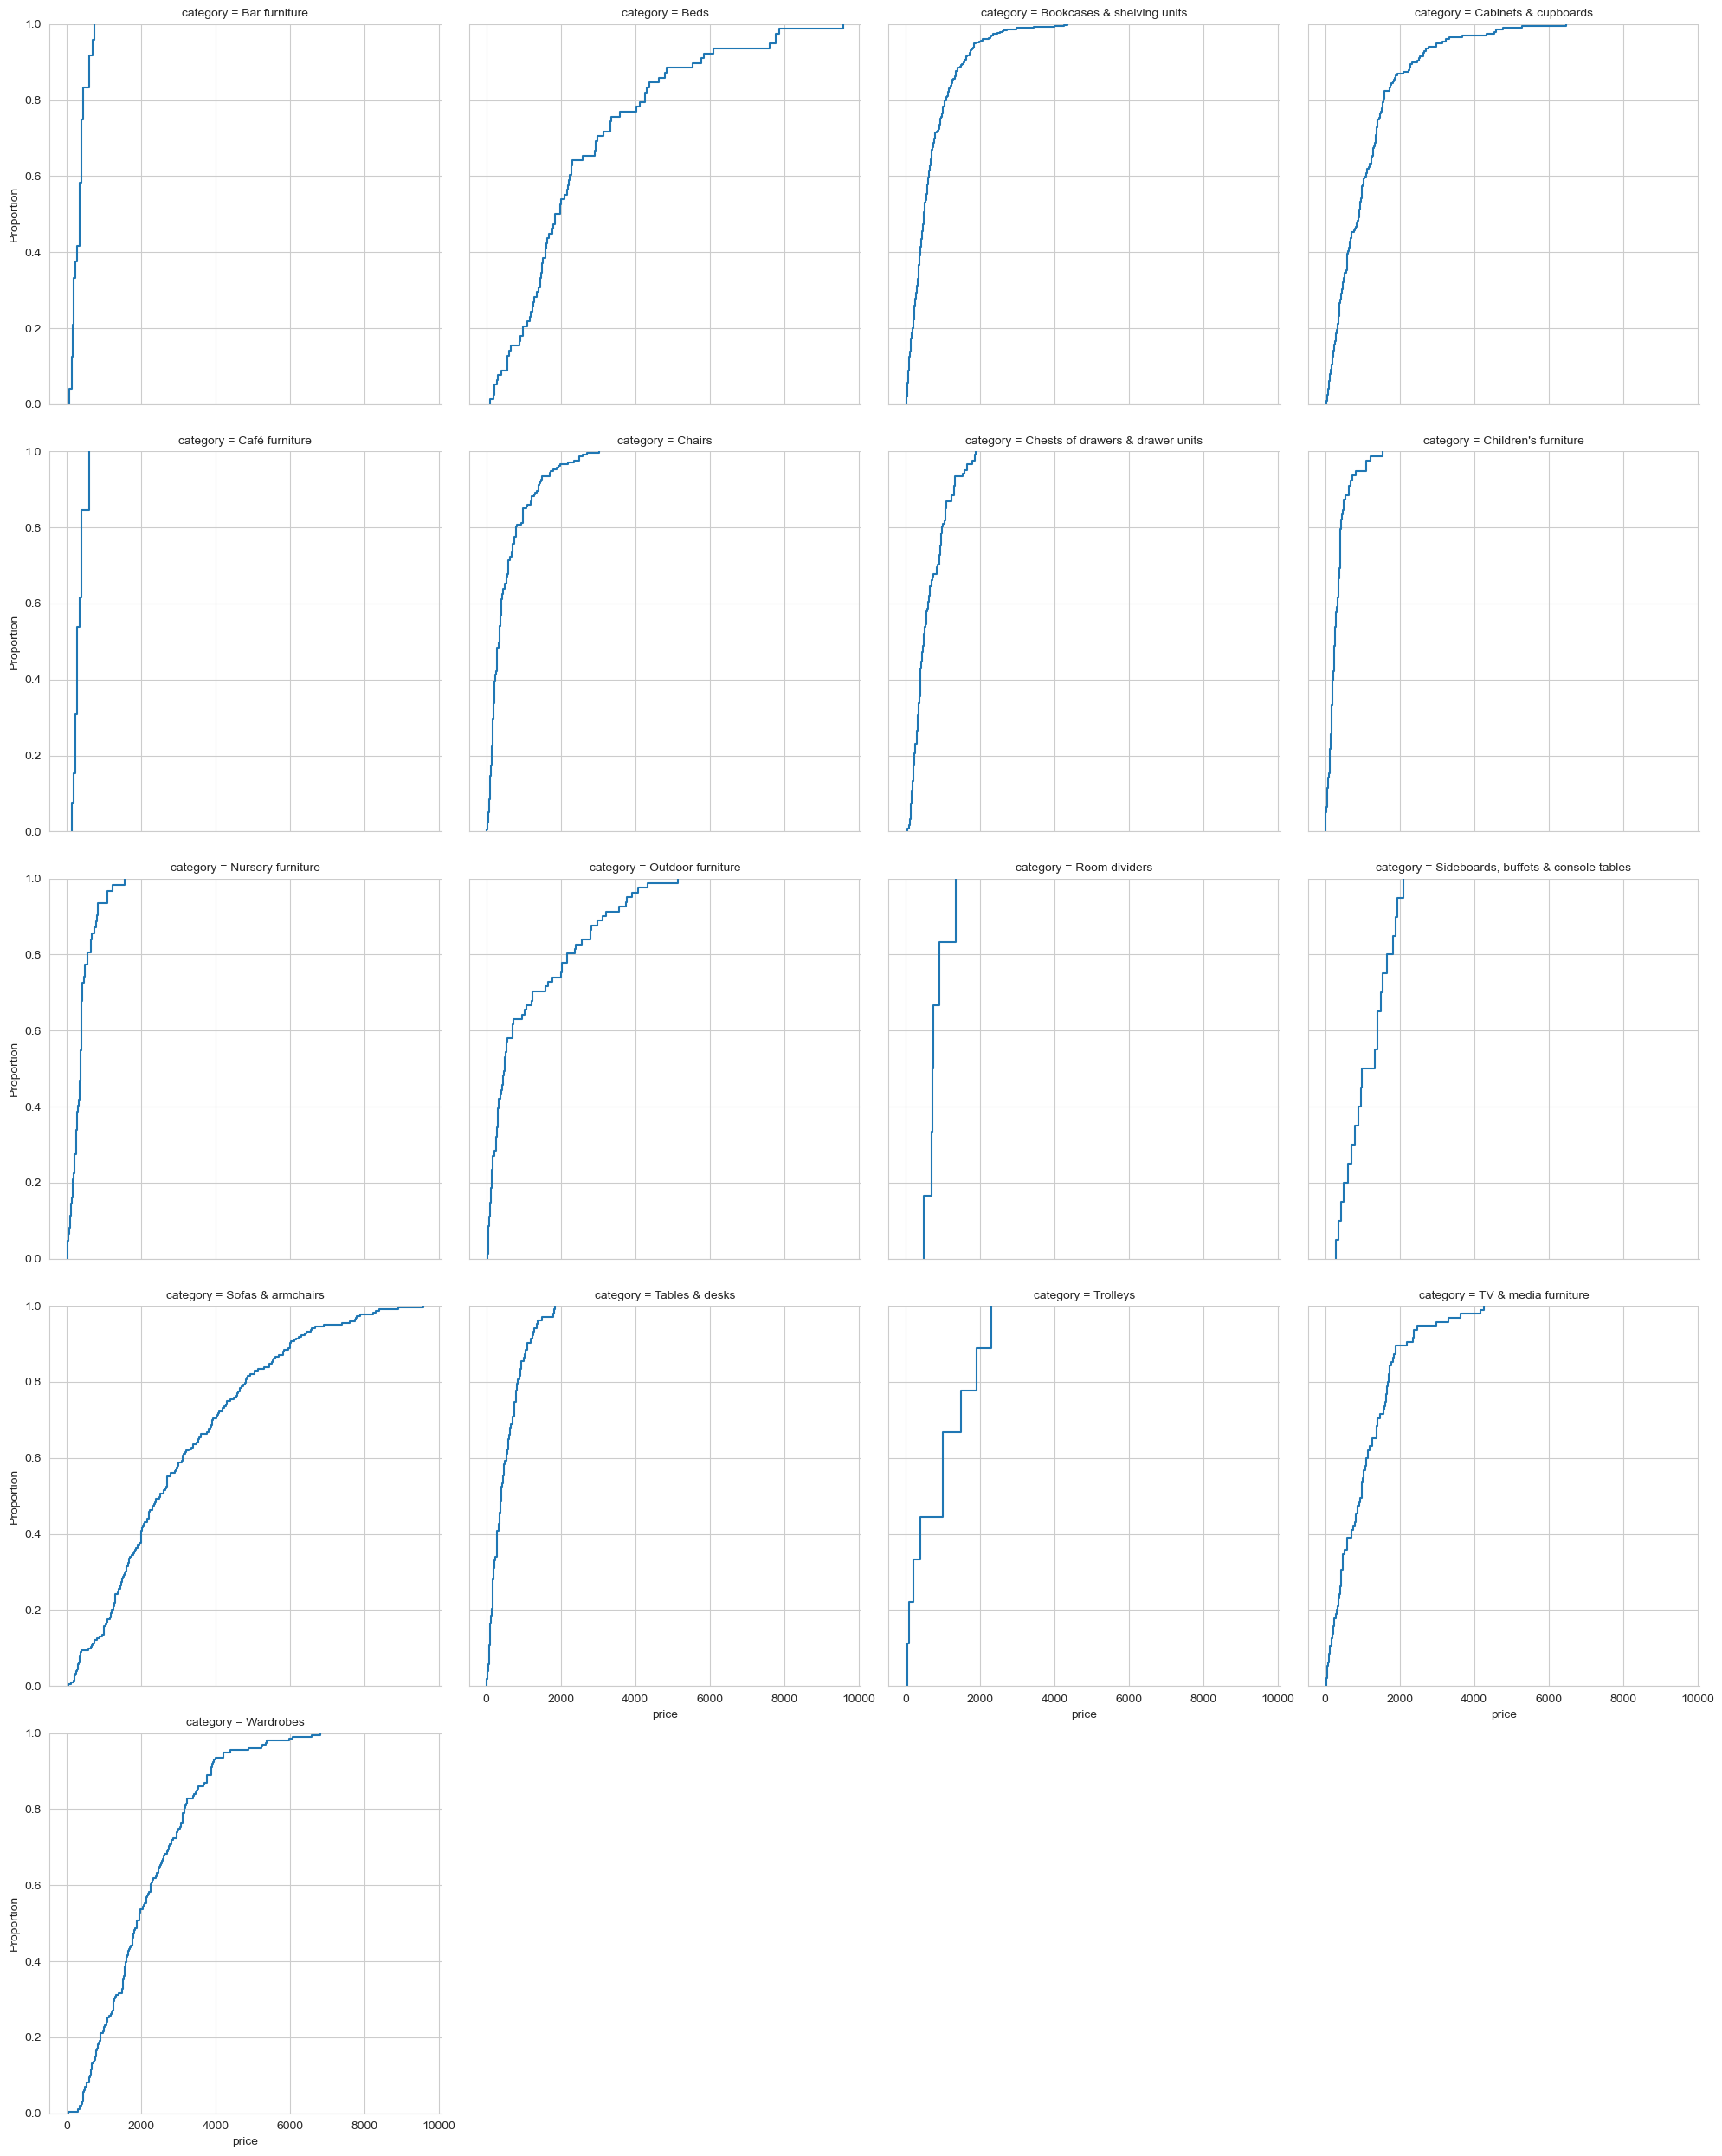

In [ ]:
sns.displot(x='price',
            col='category',
            data=df, kind="ecdf", 
             col_wrap=4)

price


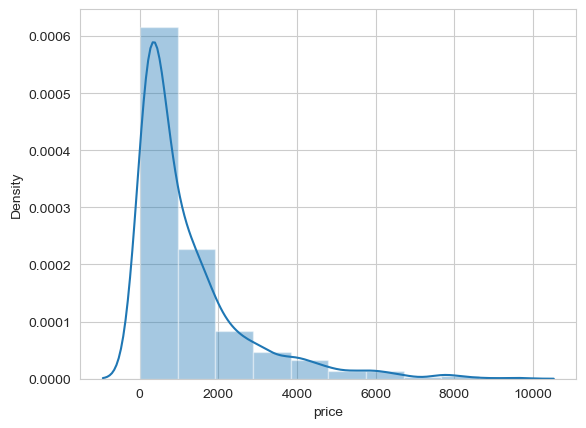

depth


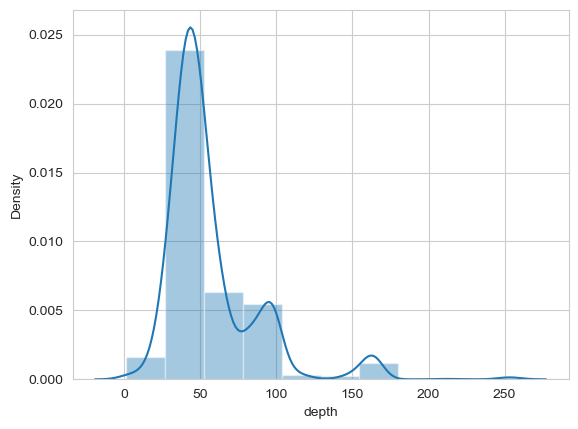

height


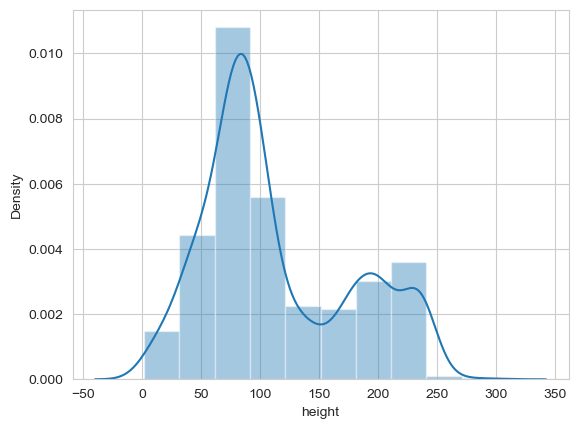

width


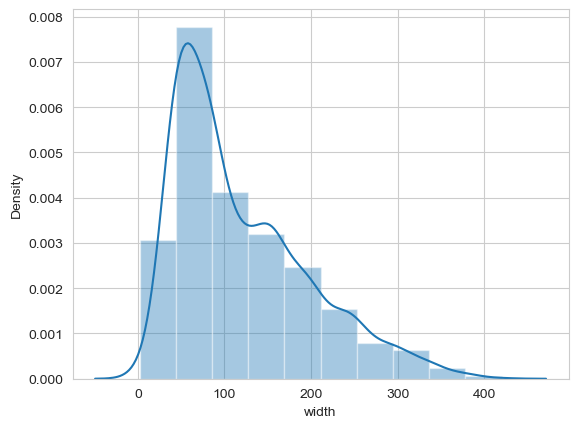

In [ ]:
for col in ['price', 'depth', 'height', 'width']:
    print(col)
    # plt.histlot(df[col])
    sns.distplot(df[col], bins=10)
    plt.show()

По гистограммам можно предположить, что эти величины имеют логнормальное распределение.

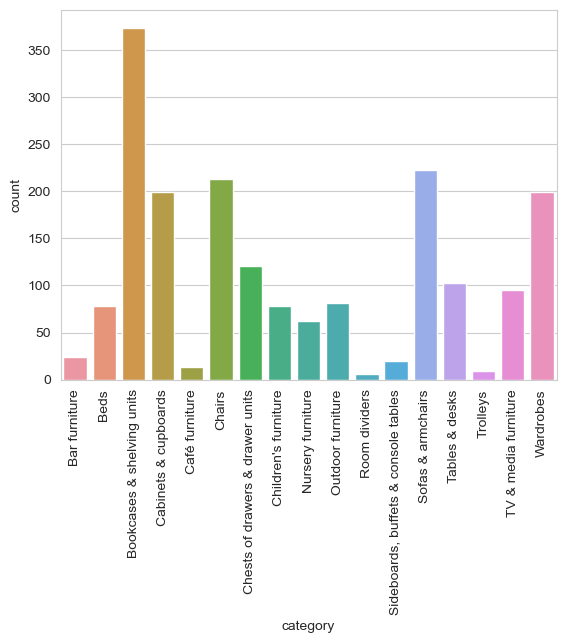

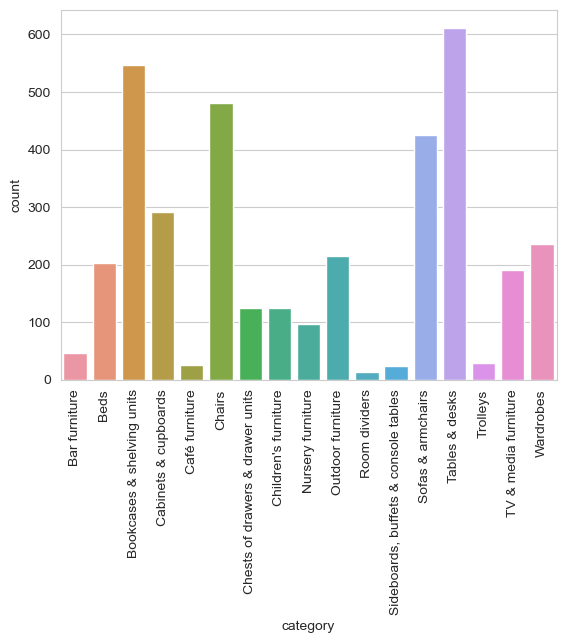

In [ ]:
#гистограмма для категорий для данных с удаленными NaN и для данных без удаленных NaN
sns.countplot(x=df['category']).set_xticklabels(df['category'].unique(), rotation=90)
plt.show()

sns.countplot(x=df_1['category']).set_xticklabels(df_1['category'].unique(), rotation=90)
plt.show()




мы видим по данным гистограммам что кол-во товаров в различных категориях различно

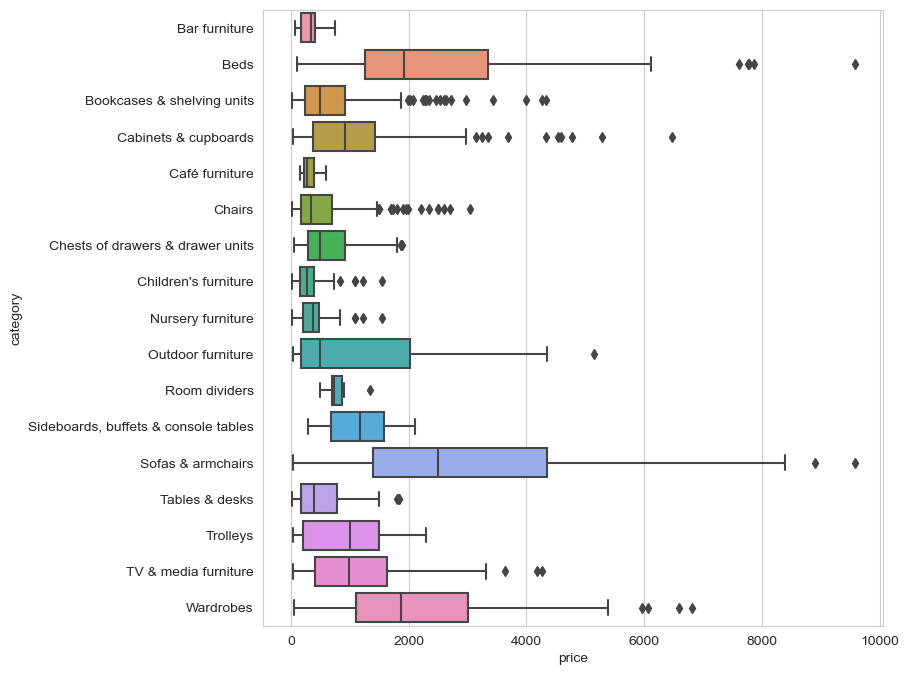

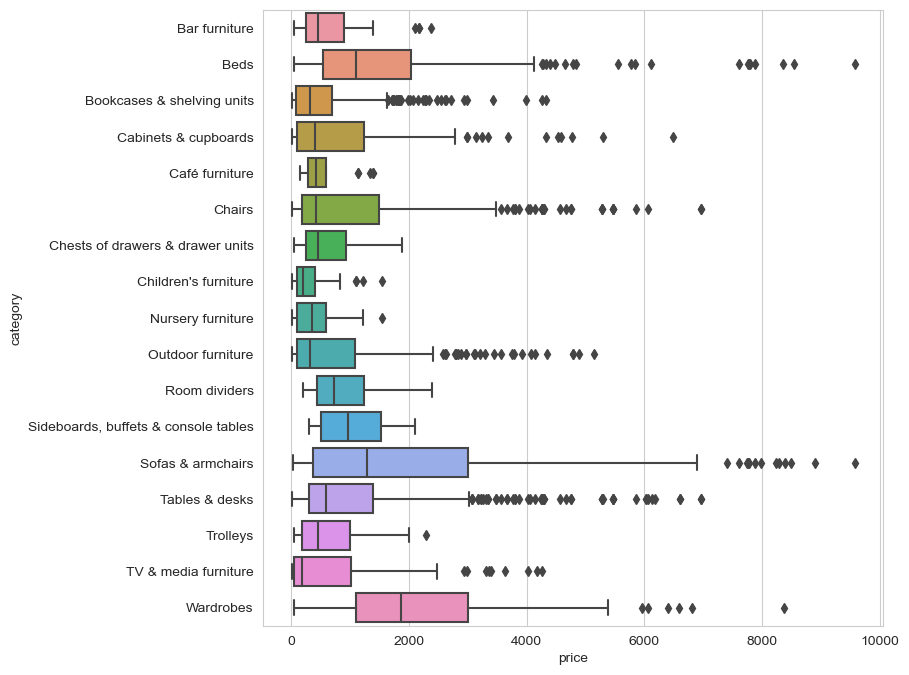

In [ ]:
plt.subplots(figsize=(8,8))
sns.boxplot(data=df, x='price', y='category')
plt.show()


plt.subplots(figsize=(8,8))
sns.boxplot(data=df_1, x='price', y='category')
plt.show()


Boxplot показал что есть выбросы в каждой категории и средние велечины, минимальные и максимальные у них также различны


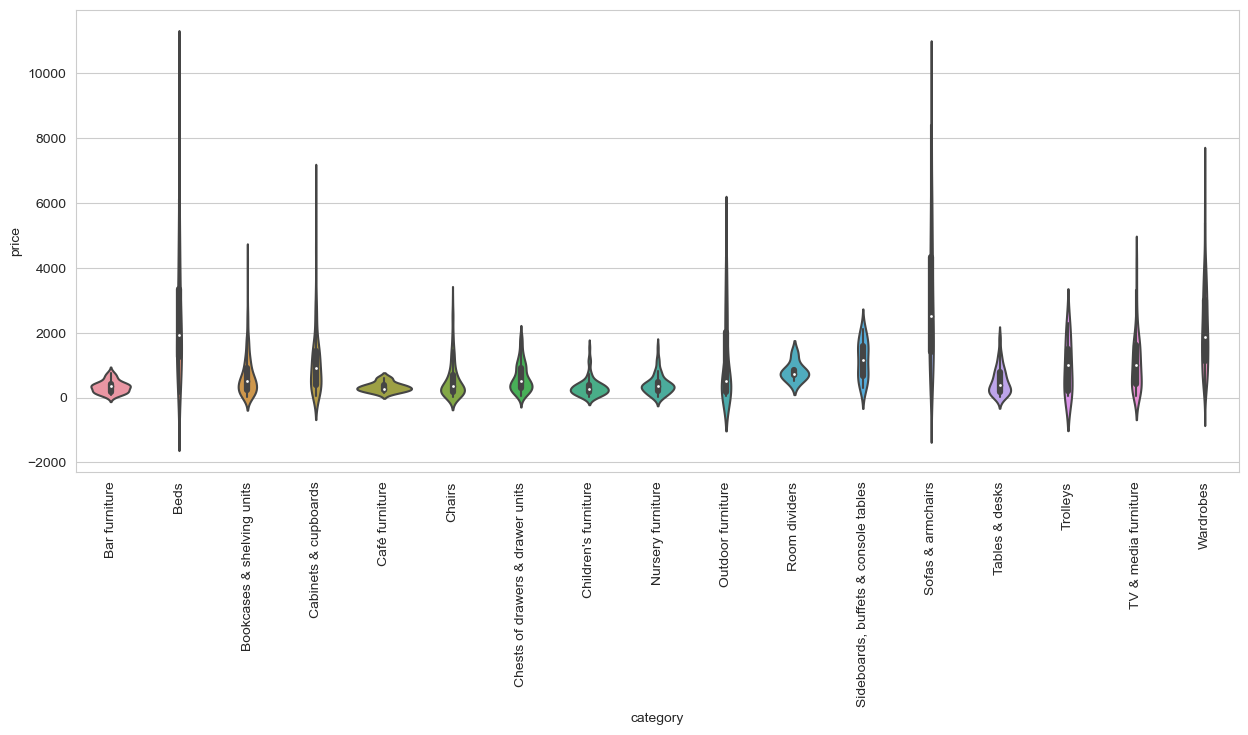

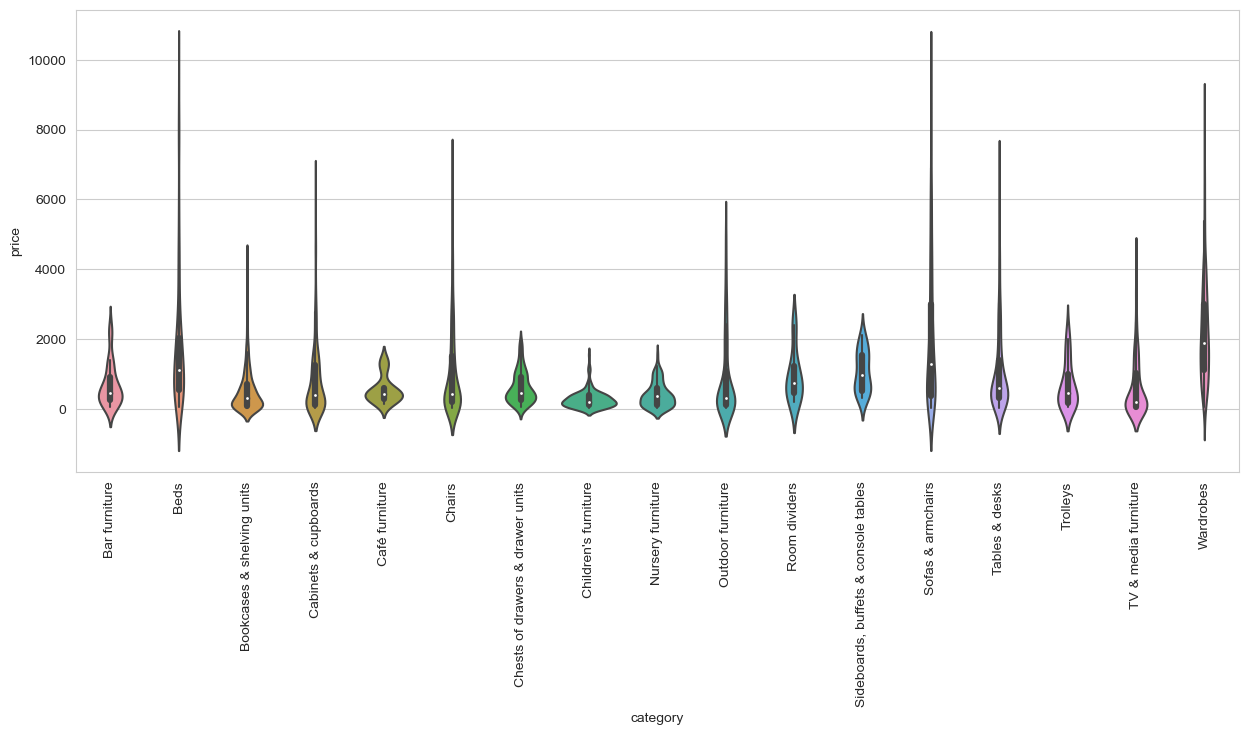

In [ ]:
plt.subplots(figsize=(15,6))
sns.violinplot(data=df, y='price', x='category')
plt.xticks(rotation=90)
plt.show()

plt.subplots(figsize=(15,6))
sns.violinplot(data=df_1, y='price', x='category')
plt.xticks(rotation=90)
plt.show()

посмотрим на цену внутри каждой категории

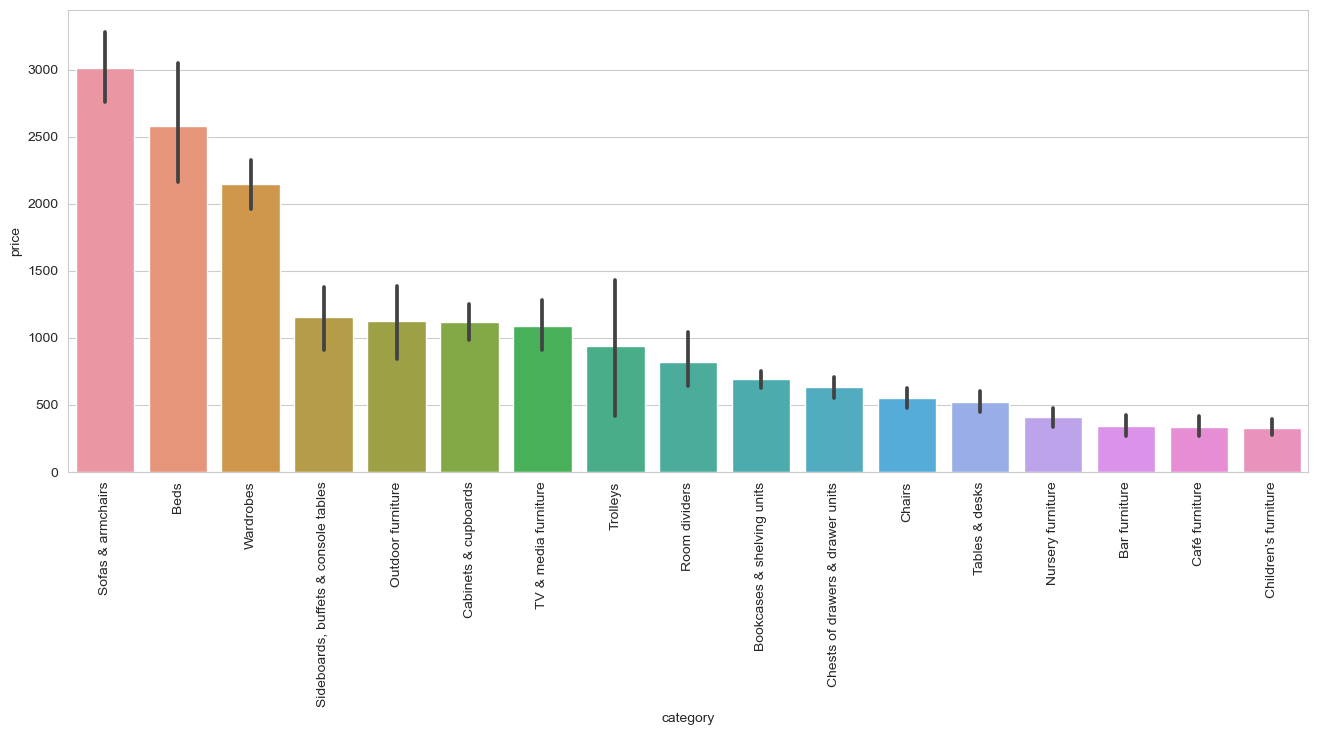

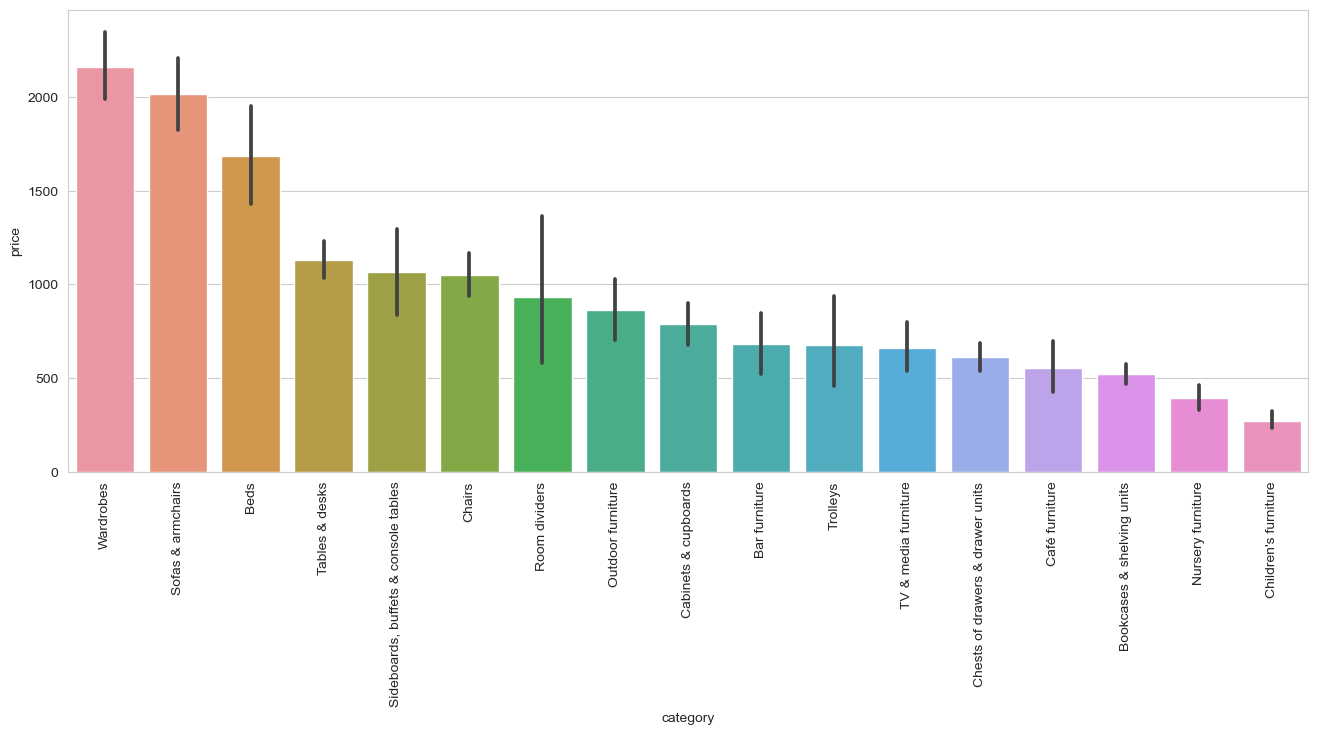

In [ ]:
plt.figure(figsize=[16, 6])
result = df.groupby(["category"])['price'].aggregate(np.mean).reset_index().sort_values('price', ascending=False)
sns.barplot(data=df, y='price', x='category', order=result['category'])
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=[16, 6])
result = df_1.groupby(["category"])['price'].aggregate(np.mean).reset_index().sort_values('price', ascending=False)
sns.barplot(data=df_1, y='price', x='category', order=result['category'])
plt.xticks(rotation=90)
plt.show()

посмотрим распределение цены внутри категорий

Bar furniture


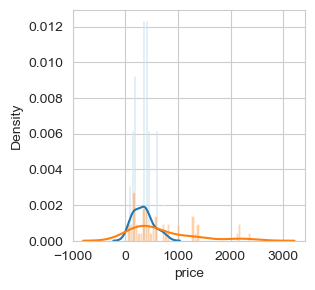

Beds


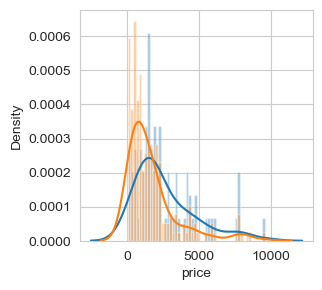

Bookcases & shelving units


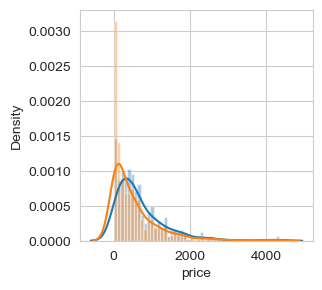

Cabinets & cupboards


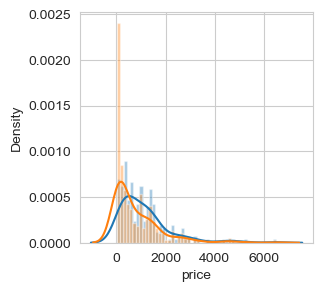

Café furniture


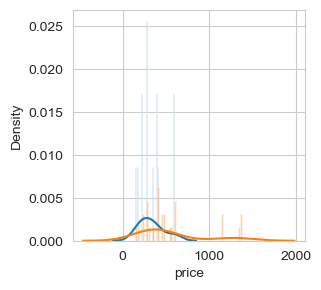

Chairs


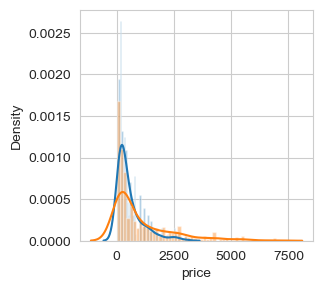

Chests of drawers & drawer units


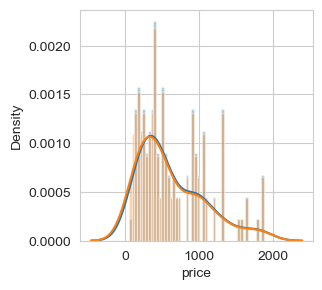

Children's furniture


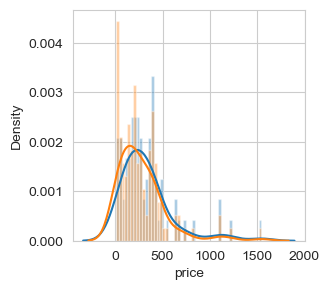

Nursery furniture


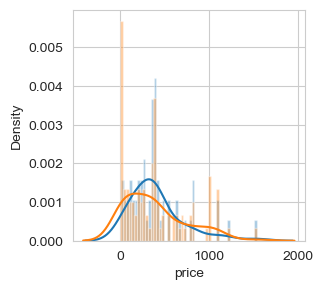

Outdoor furniture


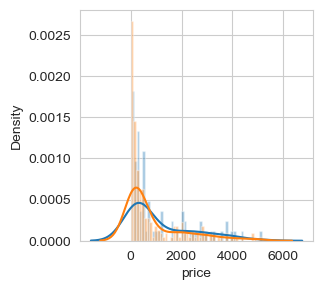

Room dividers


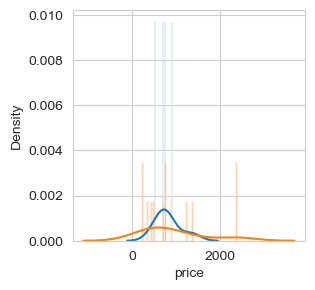

Sideboards, buffets & console tables


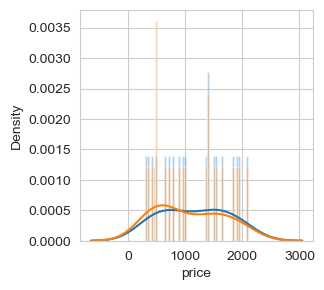

Sofas & armchairs


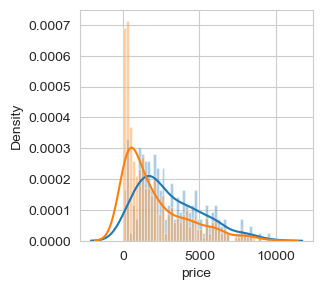

Tables & desks


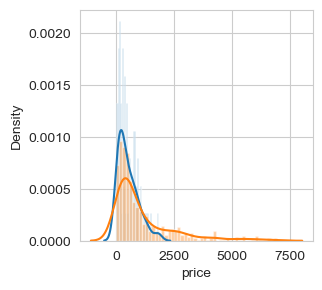

Trolleys


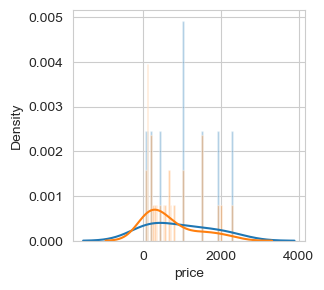

TV & media furniture


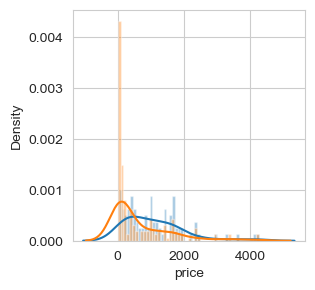

Wardrobes


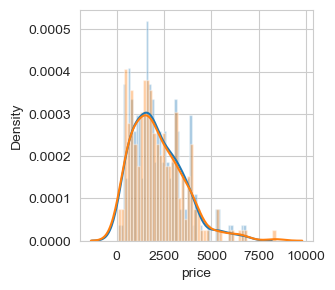

In [ ]:
for category in df.category.unique():
    print(category)
    plt.figure(figsize=[3, 3])
    db_category = df[df['category']==category]
    # plt.hist(db_category.price)
    sns.distplot(db_category.price, bins=50)
    db_category_1 = df_1[df_1['category']==category]
    sns.distplot(db_category_1.price, bins=50)
    plt.show()
 

Практически все категории имеют выбросы со стороны максимальных цен.
и распределения цен внутри различных категорий получились различны, в некоторых случаях они совподают, в некоторых нет

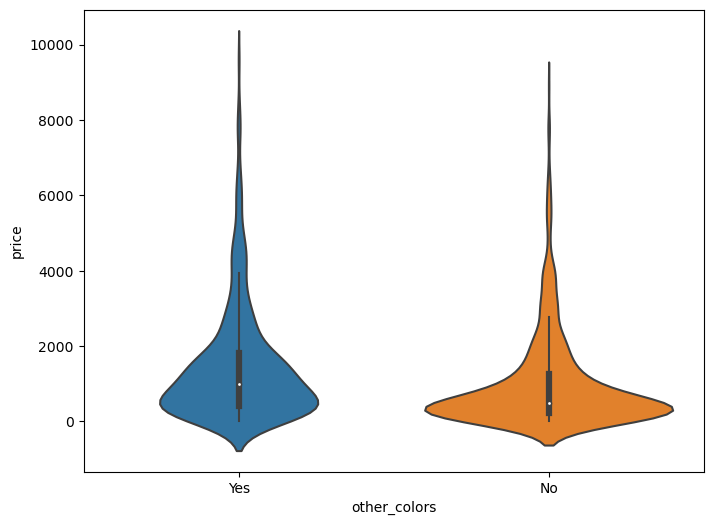

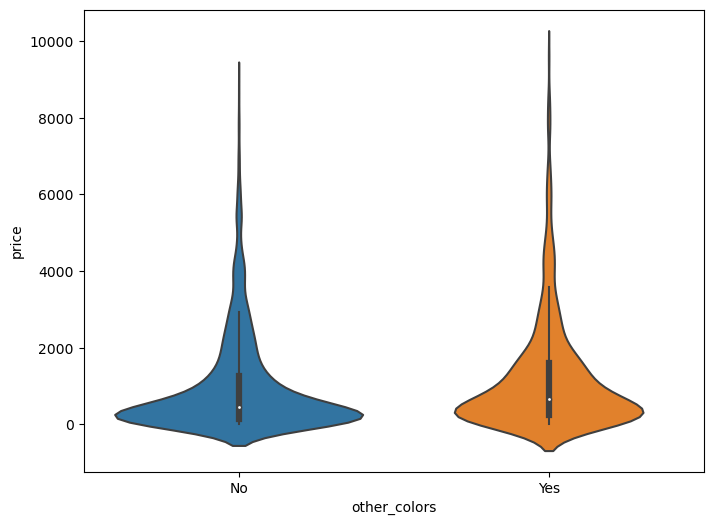

In [ ]:
plt.subplots(figsize=(8,6))
sns.violinplot(data=df, y='price', x='other_colors')
plt.show()

plt.subplots(figsize=(8,6))
sns.violinplot(data=df_1, y='price', x='other_colors')
plt.show()

распредение товаров имеющих и не имеющих других цветов, очень похожи между собой

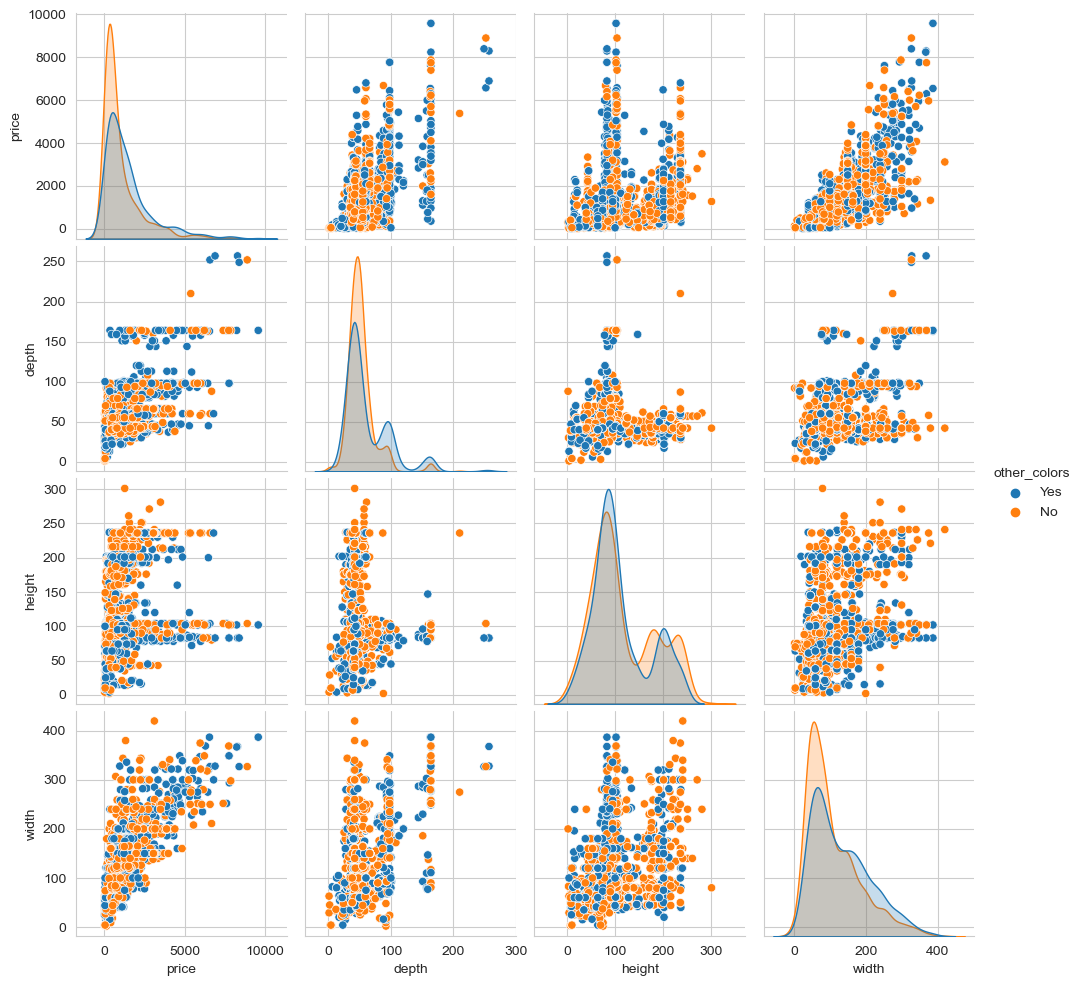

In [ ]:
sns.pairplot(df[['price','depth','height','width','other_colors']], 
			 hue='other_colors')
plt.show()

товары других цветов стоят дороже

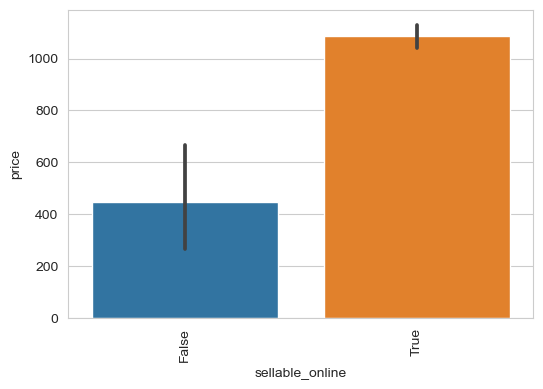

In [ ]:
plt.figure(figsize=[6, 4])
sns.barplot(data=df_1, y='price', x='sellable_online')
plt.xticks(rotation=90)
plt.show()

посмотрим соотношение товаров с одним цветом и товары которые имеют другие цвета

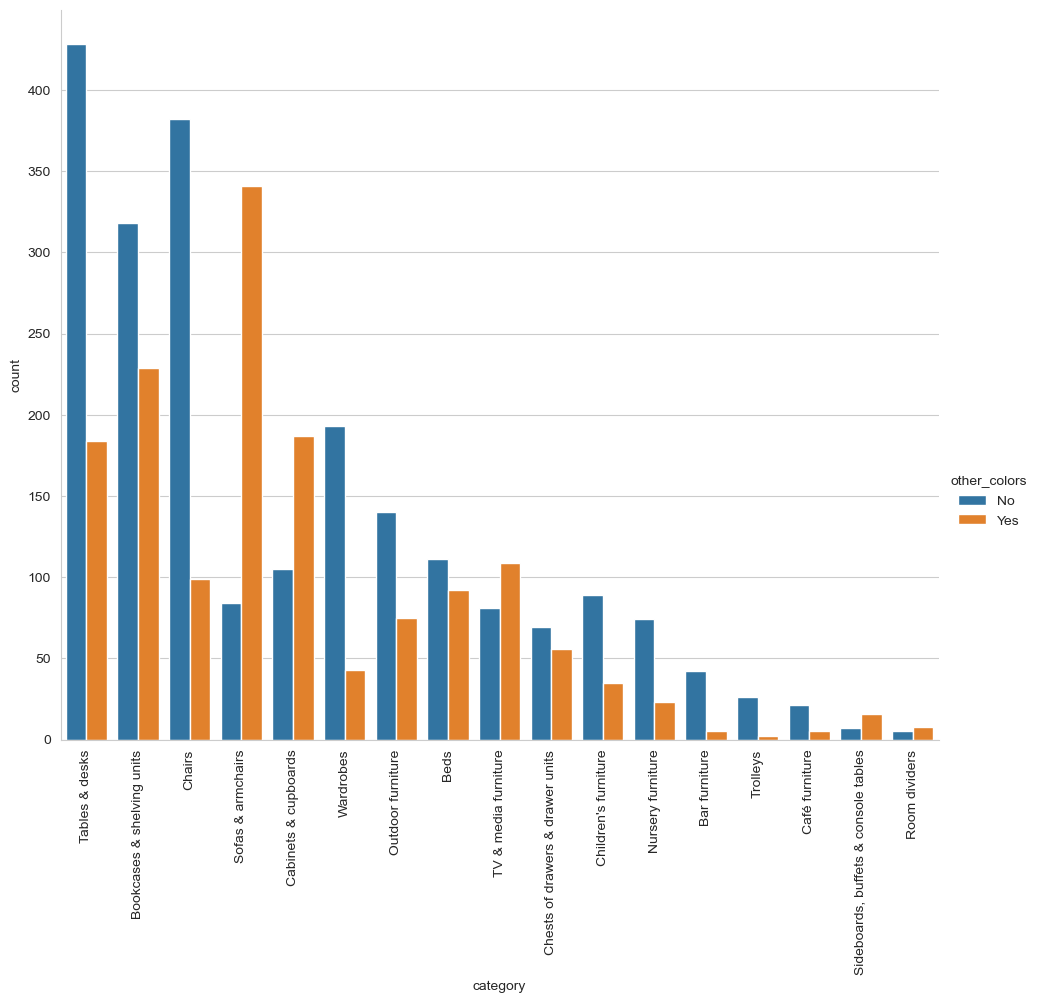

In [ ]:
order = df_1['category'].value_counts().index
sns.catplot(data=df_1, x="category", hue='other_colors', kind="count", order=order, height=8, aspect=12/10)
plt.xticks(rotation=90)
plt.show()

товары, которые можно продать через интернет, стоят дороже, чем те, которые продаются только на местном рынке

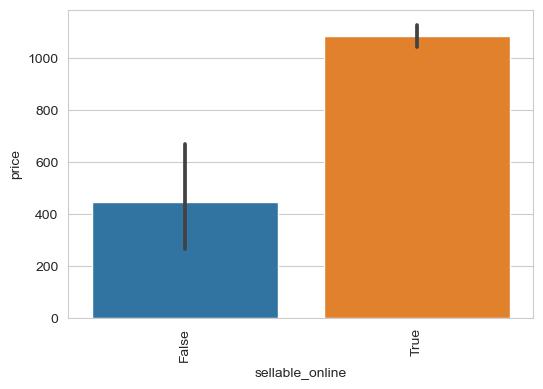

In [ ]:
plt.figure(figsize=[6, 4])
sns.barplot(data=df_1, y='price', x='sellable_online')
plt.xticks(rotation=90);
plt.show()

Похоже, цены на товары, которые имеют несколько цветов и цены на одноцветные товары - имеют одинаковое распределение.

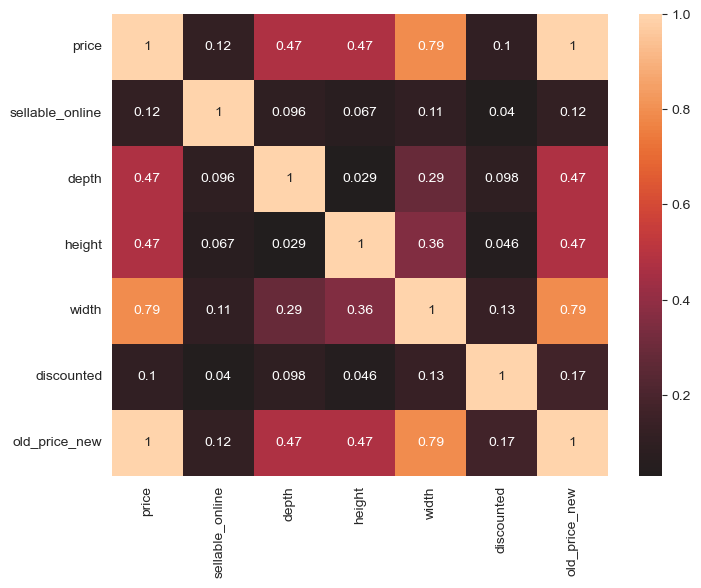

In [ ]:
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(method='spearman'), 
			xticklabels=df.corr().columns, 
			yticklabels=df.corr().columns, 
			center=0, 
			annot=True)
plt.show()

Прослеживается некоторая корелляция между ценой и габаритами изделия

# 3. Проверка гипотез

###  Гипотеза №1
По гистограмме цен можно было предположить, что цена имеет логнормальное распределение. Если случайная величина имеет логнормальное распределение, то её логарифм имеет нормальное распределение. Построим гистограмму для логарифма цен и проверим гипотезу H_0 о том, что цены имеют логнормальное распределение.

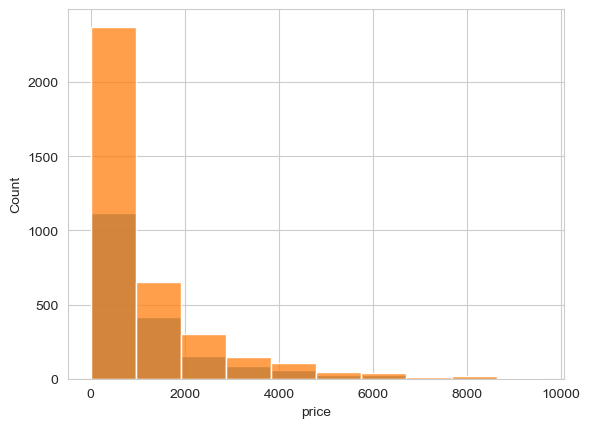

In [ ]:
sns.histplot(df.price,bins=10)
sns.histplot(df_1.price,bins=10)
plt.show()

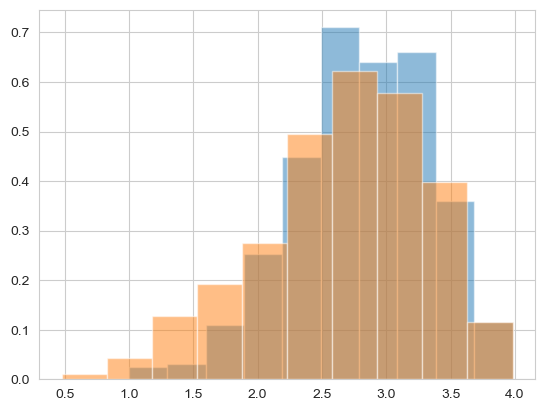

In [ ]:
plt.hist(np.log10(df.price), bins=10,density=True, alpha=0.5)
plt.hist(np.log10(df_1.price), bins=10,density=True, alpha=0.5)
plt.show()
#print(np.log10(df.price))

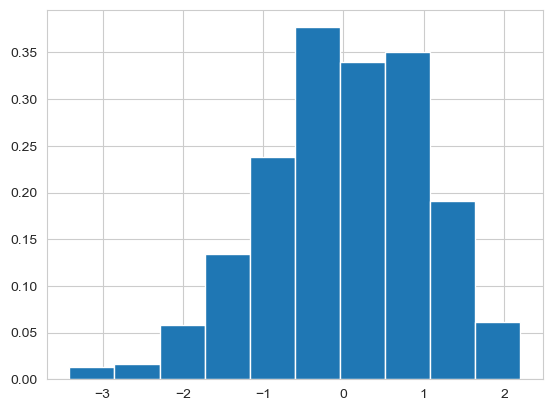

In [ ]:
# стандартизация данных
sample_h = (np.log10(df.price)-np.log10(df.price).mean())/np.log10(df.price).std()
#print(sample_h)
hist_h = plt.hist(sample_h, bins=10,density=True)
plt.show()

In [ ]:
def check_frequency(sample, database):

    list_p_value = []
    
    h0_1_p_value = stats.shapiro(sample).pvalue
    h0_1_p_value_1 = stats.shapiro(np.log10(database)).pvalue
    h0_1_p_value_2 = stats.kstest(sample, cdf=stats.norm.cdf).pvalue
    try: 
        h0_1_p_value_3 = stats.normaltest(sample).pvalue
    except:
        h0_1_p_value_3 = 'None'
    h0_1_p_value_4 = stats.ks_2samp(sample, stats.norm.rvs(size=len(sample))).pvalue
    h0_1_p_value_5 = stats.mannwhitneyu(sample, stats.norm.rvs(size=len(sample))).pvalue
    list_p_value= [h0_1_p_value, h0_1_p_value_1, h0_1_p_value_2, h0_1_p_value_3, h0_1_p_value_4, h0_1_p_value_5]

    return list_p_value 

Используем критерий Шапиро на разных данных и другие тесты для проверки гипотезы о нормальности распределения.

In [ ]:
print(check_frequency(sample_h, df.price), sep='\n')

[3.3519194364561855e-11, 3.351321997691059e-11, 0.003513013306223769, 8.258903404661385e-10, 0.05304142105403381, 0.37196377300038563]


аналогично проделываем отдельно для каждой категории


In [ ]:
for category in df.category.unique():
    print(category)
    sample_h = (np.log10(df[df.category == category].price)-\
                np.log10(df[df.category == category].price).mean())/\
                    np.log10(df[df.category == category].price).std()
    l = check_frequency(sample_h, df[df.category == category].price)
    print(l)
    

Bar furniture
[0.23954451084136963, 0.23954451084136963, 0.2577122320571966, 0.5654081030241958, 0.686017125117228, 0.2787030082819374]
Beds
[0.00919182039797306, 0.009191513992846012, 0.3916926663345539, 0.013078288244699511, 0.5459989251653901, 0.47072864352878774]
Bookcases & shelving units
[2.192630859099154e-07, 2.1924283544194623e-07, 0.004667830796014304, 1.931412817198202e-06, 0.022270044991397196, 0.7494865144084251]
Cabinets & cupboards
[0.00040031521348282695, 0.00040033418918028474, 0.04028255239763723, 0.002941064897344882, 0.0864661252002529, 0.8705461701463598]
Café furniture
[0.7479234933853149, 0.7479236125946045, 0.9345515955571193, 0.9683654323388817, 0.8978057035171046, 1.0]
Chairs
[0.25156399607658386, 0.25153452157974243, 0.698280763056427, 0.5901882387187938, 0.7482622870972879, 0.6645245479120478]
Chests of drawers & drawer units
[0.05956901237368584, 0.05956641584634781, 0.30492797593925136, 0.21442961981976202, 0.24132588773814823, 0.9985346186263191]
Children

Так как p-value очень маленькое, то с большой долей уверенности критерий Шапиро нашу нулевую гипотезу отвергает, хотя по гистограммам этого не скажешь. Возможно гистограммы имею очень мало корзин. Увеличим, количество корзин до 50

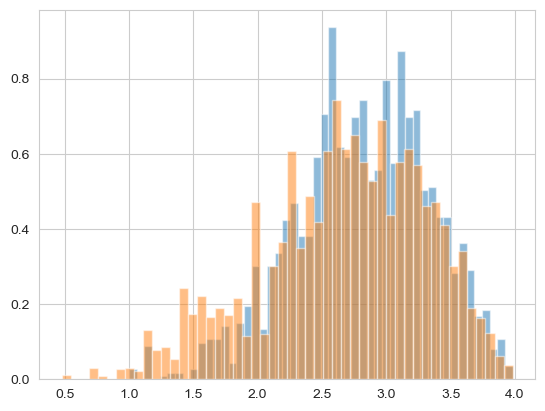

In [ ]:
plt.hist(np.log10(df.price), bins=50,density=True, alpha=0.5)
plt.hist(np.log10(df_1.price), bins=50,density=True, alpha=0.5)
plt.show()

Видны множественные выбросы слева и справа от купола. Гипотеза о нормальном распределении цен оказалась не состоятельной.

Bar furniture


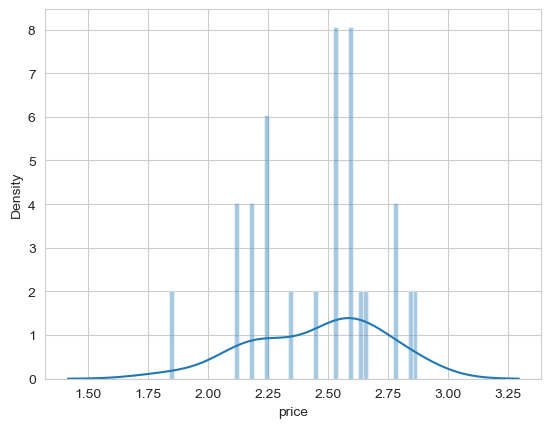

Beds


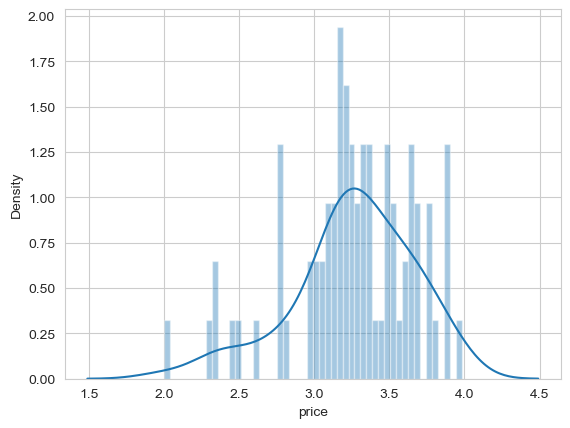

Bookcases & shelving units


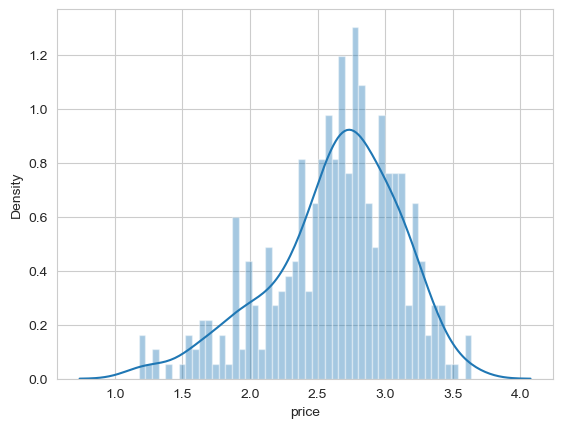

Cabinets & cupboards


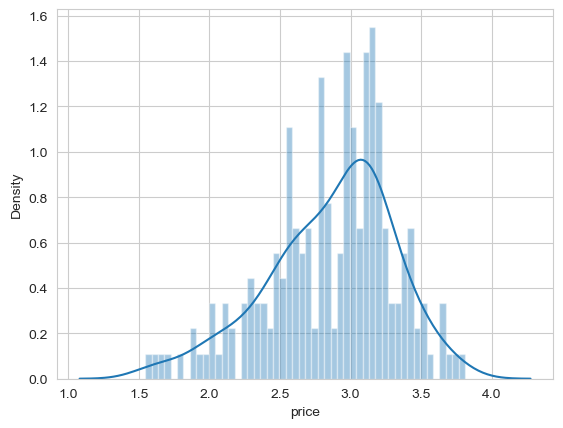

Café furniture


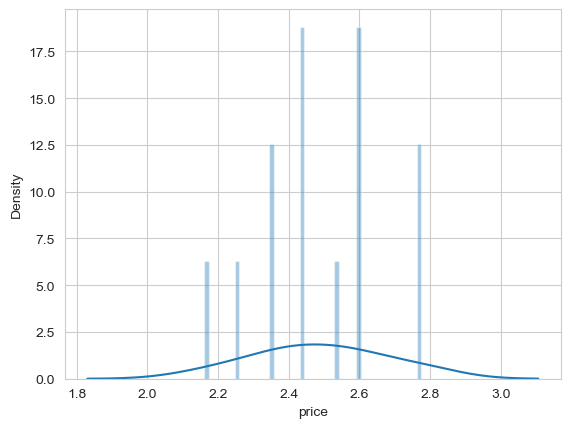

Chairs


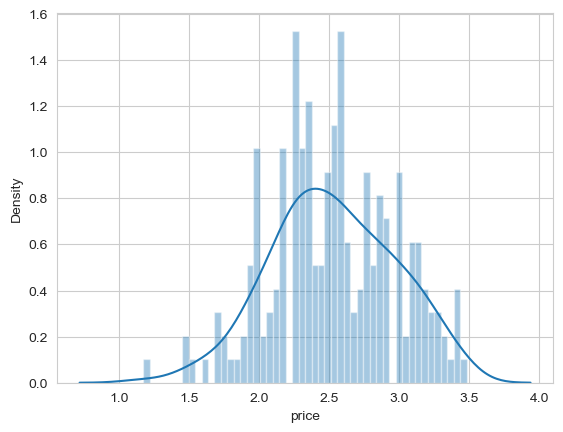

Chests of drawers & drawer units


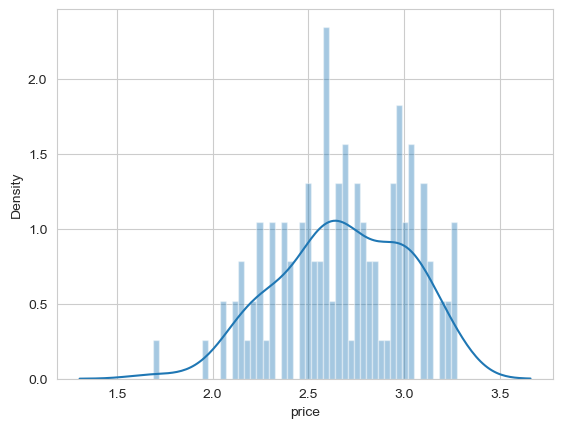

Children's furniture


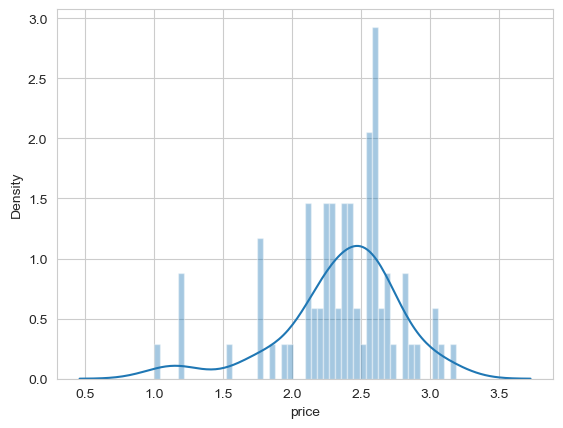

Nursery furniture


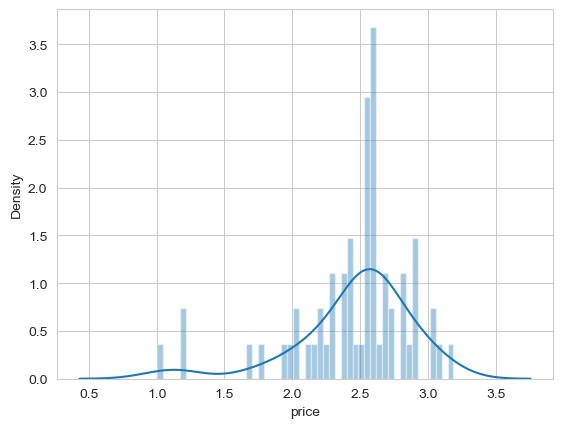

Outdoor furniture


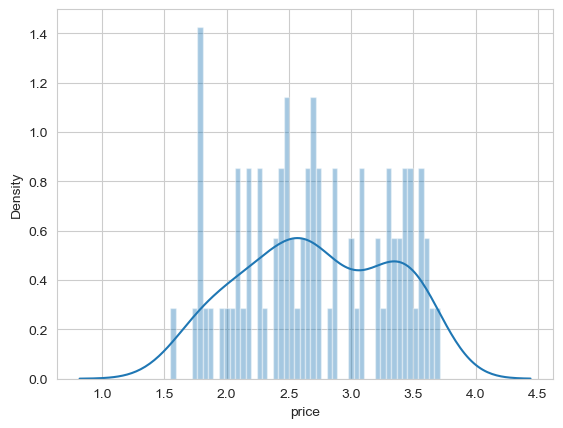

Room dividers


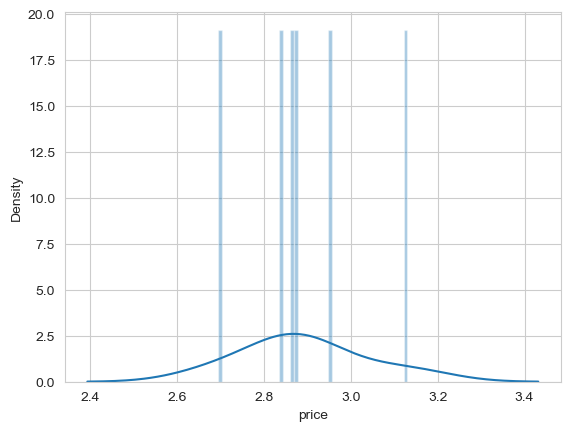

Sideboards, buffets & console tables


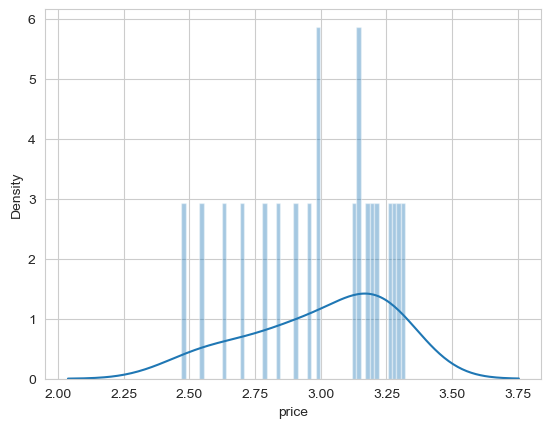

Sofas & armchairs


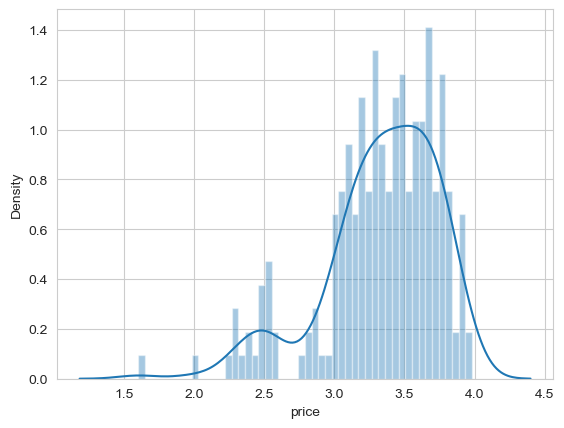

Tables & desks


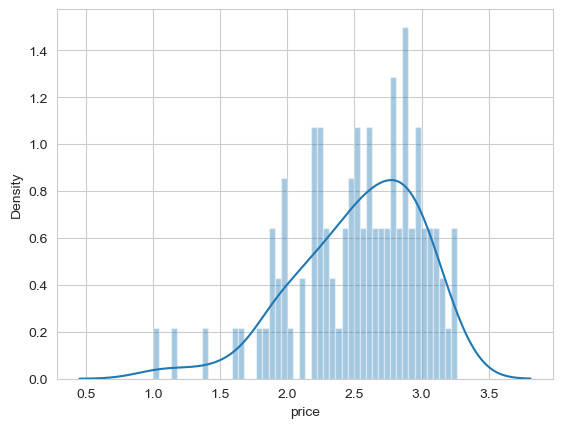

Trolleys


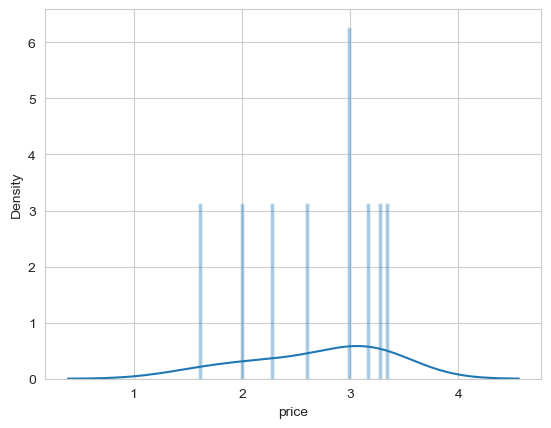

TV & media furniture


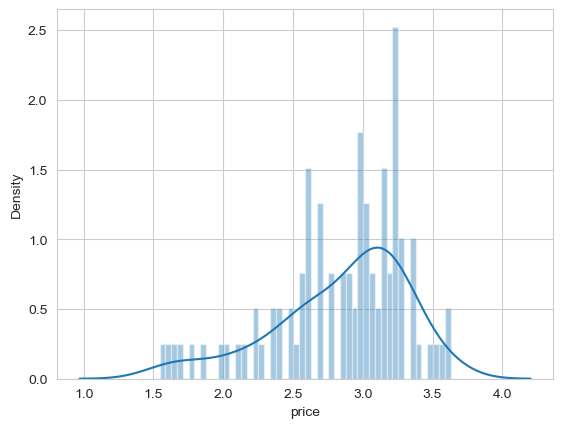

Wardrobes


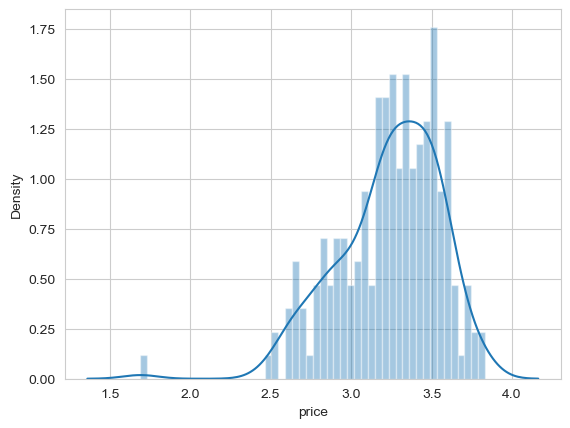

In [ ]:
for category in df.category.unique():
     print(category)
     sns.distplot(np.log10(df[df.category==category].price), bins=50)
     # plt.hist(np.log10(df[df.category==category].price), bins=50,density=True)
     plt.show()

также видим множественные выбросы в каждой из категорий в сторону максимальных и минимальных цен

,price
3,-0.810206
4,-0.700516
5,-0.616139
6,-0.768018
8,-0.768018
...,...
3683,0.027235
3684,0.016688
3685,0.617873
3686,1.943294


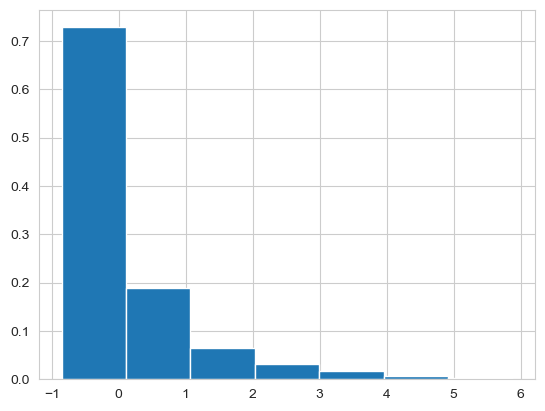

In [ ]:
sample_h_2 = pd.DataFrame(((df.price)-(df.price).mean())/(df.price).std())
hist_h_2 = plt.hist(sample_h_2, bins=7,density=True)
sample_h_2

Может это Пуассон?

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.poisson.html

к сожалению у меня не получилось подобрать параметры чтобы проверить данную гипотезу
внутри категорий, есть категории в которых распределение также похоже на Пуассоновское или га Гамма

In [ ]:
from sklearn import preprocessing
scale_features_std = preprocessing.StandardScaler()
features_train = scale_features_std.fit_transform(np.array(df.price).reshape(-1, 1))

features_test = scale_features_std.transform(np.array(df.price).reshape(-1, 1))
print(features_test,features_train,sep="\n")

sample_h_norm = (df.price-df.price.mean())/df.price.std()
print(sample_h_norm)

[[-0.81041949]
 [-0.7007006 ]
 [-0.61630146]
 ...
 [ 0.61803599]
 [ 1.94380583]
 [ 0.57935305]]
[[-0.81041949]
 [-0.7007006 ]
 [-0.61630146]
 ...
 [ 0.61803599]
 [ 1.94380583]
 [ 0.57935305]]
3      -0.810206
4      -0.700516
5      -0.616139
6      -0.768018
8      -0.768018
          ...   
3683    0.027235
3684    0.016688
3685    0.617873
3686    1.943294
3688    0.579200
Name: price, Length: 1898, dtype: float64


### Гипотеза №2
Проверим гипотезу о том что цены на товары которые имеют несколько цветов статистически не отличаются от цен на одноцветные товаров.

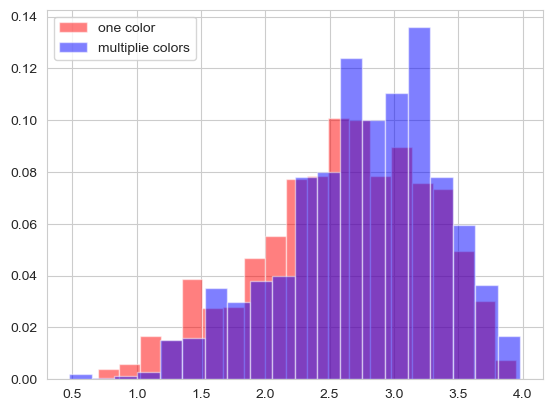

In [ ]:
one_color = df_1[df_1['other_colors'] == 'No']['price'].apply(np.log10)
mult_color = df_1[df_1['other_colors'] == 'Yes']['price'].apply(np.log10)
one_color.name, mult_color.name = 'one color', 'multiplie colors'

one_color.hist(alpha=0.5, color='red', weights=[1./len(one_color)]*len(one_color), bins=20)
mult_color.hist(alpha=0.5, color='blue', weights=[1./len(mult_color)]*len(mult_color), bins=20)
#plt.axvline(one_color.mean(), color='red', alpha=0.8, linestyle='dashed')
#plt.axvline(mult_color.mean(), color='blue', alpha=0.8, linestyle='dashed')
#plt.axvline(one_color.median(), color='red', alpha=0.8, linestyle='dotted')
#plt.axvline(mult_color.median(), color='blue', alpha=0.8, linestyle='dotted')
plt.legend([one_color.name, mult_color.name])
plt.show()

Мы уже знаем что цена не имеет нормального распределения. Проверим критерий Манна-Уитни (он работает с не нормальным распределением и непарными выборками).

In [ ]:
stats.mannwhitneyu(one_color, mult_color).pvalue

1.310097297042337e-11

p-value - меньше 0.01, гипотеза отвергнута. Разница цен на многоцветные и одноцветные товары статистически значима. 
Так как распределение цен не существенно отличается от нормального вычислим p-значение t-теста Стьюдента.

In [ ]:
stats.ttest_ind(one_color, mult_color, equal_var=False).pvalue

1.3866958571204838e-12

Данный тест также подтверждает несостоятельность нашей гипотезы.

# 4. Предсказание цены на мебель

### Посоветуйте, какие столбцы не следует включать в модель и почему.

Мы уже на первом этапе удалили колонки `item_id`, `link`.

`item_id`, `link` не нужны так как являются уникальными для каждого товара и никак не помогут спрогнозировать цену товара.

`short_description` и `name` - Эти поля можно было бы использовать, например, если описание содержит слово "эксклюзивный", то вероятно цена будет выше. Но мы не будем использовать их в нашей модели и поэтому их тоже можно удалить.

Также можно удалить колонку `sellable_online`. Так как она не репрезентативна:
```
value_counts()

True     3666
False      28
Name: sellable_online, dtype: int64
```

Так как основная часть товаров не имеет данных по старой цене, то поле old_price также можно удалить 
```
No old price    3040
SR 995            12
SR 1,385          11
SR 595            10
SR 275             8
                ... 
SR 3,145           1
SR 39              1
SR 2,105           1
SR 752             1
SR 1,050           1
Name: old_price, Length: 365, dtype: int64
```

### Создайте пайплайн для кросс-валидации для обучения и оценки модели, включая (при необходимости) такие шаги, как присвоение пропущенных значений и нормализация.

На этапе EDA мы обнаружили, что некоторые поля имеют пустые значения или "мусор".

_Габариты_

Габариты имеют пустые значения. Есть несколько стратегий заполнения пустых значений габаритов.

1. Можно просто удалить все строки у которых имеются пустые значения.
2. Воспользоваться SimpleImputer библиотеки sklearn и заполнить пустые значения каким-то (например, медианным) значением. 
3. Придумать свой вариант (см. дальше)

_Дизайнеры_

Колонка `designer` содержит "мусор" (строки начинающиеся с цифр), который надо будет удалить и как-то заполнить пустые значения. При более детальном рассмотрении можно увидеть, что некоторые товары разрабатывала группа дизайнеров, например 
```
Francis Cayouette/K Hagberg/M Hagberg
K Hagberg/M Hagberg/Francis Cayouette
```
и также можно заметить, что в данном случае строки разные, а состав дизайнеров один и тот же. Здравый смысл подсказывает, что необходимо привести все строки к одному виду, например, можно отсортировать имена дизайнеров по алфавиту.

Также очень много (около 30%) товаров имеет в списке дизайнеров строку `IKEA of Sweden`. Учитывая что все эти товары изготовлены IKEA, то, возможно, это значение также является мусором.


In [ ]:
for category in df.category.unique():
    print(category)
    print(df[df.category==category].describe())
    print()

Bar furniture
            price      depth      height      width  discounted  old_price_new
count   24.000000  24.000000   24.000000  24.000000   24.000000      24.000000
mean   338.416667  47.541667   94.666667  45.833333    0.041667     343.333333
std    184.885844   5.356663   17.061695   8.095445    0.204124     181.952375
min     69.000000  36.000000   43.000000  38.000000    0.000000      69.000000
25%    175.000000  44.000000   90.750000  40.000000    0.000000     175.000000
50%    345.000000  47.500000  100.500000  43.000000    0.000000     345.000000
75%    405.000000  51.000000  103.000000  50.000000    0.000000     405.000000
max    745.000000  60.000000  114.000000  74.000000    1.000000     745.000000

Beds
             price       depth      height       width  discounted  \
count    78.000000   78.000000   78.000000   78.000000   78.000000   
mean   2580.769231   82.756410   67.153846  174.423077    0.320513   
std    2075.772960   33.678845   32.533330   67.988448    0

разбег между минимум и максимум в некоторых категориях довольно большой

In [ ]:
df['designer'].value_counts()

IKEA of Sweden                                                                                                                                                                                                                                                                                                                            427
Ola Wihlborg                                                                                                                                                                                                                                                                                                                              100
Jon Karlsson                                                                                                                                                                                                                                                                                                                               8

In [ ]:
'''
Процедура приведения колонки designer к "нормальному виду"
value - строка, состав дизайнеров
removeIKEA - удалять или нет IKEA of Sweden
emptyValue - чем заменять неверные значения, по умолчанию np.nan, можно поробовать менять на пустую строку или "IKEA of Sweden"
'''

import contextlib
def cleanDesigners(value, removeIKEA=False, emptyValue=np.nan):
    #если это не строка возвращаем само значение
    if not isinstance(value, str):
        return value
    #если строка начинается на цифру, возвращаем пустое значение
    if len(value)>0 and value[0].isdigit():
        return emptyValue
    #разбиваем строку по / 
    designers = value.split("/")
    if removeIKEA:
        #пытаемся удалить "IKEA of Sweden"
        with contextlib.suppress(Exception):
            designers.remove("IKEA of Sweden")
    return '/'.join(sorted(designers)) if len(designers) > 0 else emptyValue


Добавим новую колонку `designer_clean` - поле designer без мусора, с отсортированным списком дизайнеров. Пустые значения запролним "IKEA of Sweden"

Если колонка `designer` содержала 381 уникальное значение, то `designer_clean` - 199


In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-11-03/ikea.csv", 
				 index_col=0).drop_duplicates()
df = df[df.old_price.str.find('pack') == -1]
df["designer_clean"] = df["designer"].apply(cleanDesigners, args=(False, "IKEA of Sweden")) #error to nan
df["designer_clean"].value_counts()

IKEA of Sweden                                                     969
Ehlén Johansson                                                    159
Francis Cayouette                                                  151
Ehlén Johansson/IKEA of Sweden                                     145
Ola Wihlborg                                                       130
                                                                  ... 
Eva Lilja Löwenhielm/IKEA of Sweden/Jon Karlsson                     1
A Huldén/S Dahlman                                                   1
Ehlén Johansson/Fredriksson/Hilland/IKEA of Sweden/L Löwenhielm      1
Malin Unnborn                                                        1
Lars Norinder                                                        1
Name: designer_clean, Length: 199, dtype: int64

In [ ]:
df.isnull().sum()

item_id                 0
name                    0
category                0
price                   0
old_price               0
sellable_online         0
link                    0
other_colors            0
short_description       0
designer                0
depth                1456
height                981
width                 583
designer_clean          0
dtype: int64

Для заполнения отсутствующих габаритов воспользуемся возможностями SimpleImputer. Так же нам необходимо перевести категорийные переменные в цифровой вид. Так как категории товаров это неупорядоченные данные, то воспользуемся OneHotEncoder и построим соответствующий Pipeline

Так как мы хотим прогнозировать цену - вещественное число, то воспользуемся каким-нибудь из регрессоров, например деревом решений DecisionTreeRegressor()

Scikit-Learn предоставляет класс Pipeline, призванный помочь справиться с последовательностями трансформаций.

Конструктор Pipeline принимает список пар "имя/оценщик': определяющий последовательность шагов. Все кроме последнего оценщика обязаны быть трансформаторами (т.е. они должны иметь метод fit_transform() ). Имена могут быть какими угодно (пока они не содержат два подчеркивания (_)).
Вызов метода fit() конвейера приводит к последовательному вызову методов fit_transform() всех трансформаторов с передачей вывода каждого вызова в качестве параметра следующему вызову до тех пор, пока не будет достигнут последний оценщик, для которого просто вызывается метод fit().


In [ ]:
# df1 = df
X = df[['depth','width','height','category','designer_clean','other_colors']]
#X = df1[['depth','width','height','category']]
Y = df['price']
X_train, X_test, Y_train, Y_test = sk.model_selection.train_test_split(X, Y, test_size=0.2, random_state=42)

numeric_transf = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transf = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

col_prepr = ColumnTransformer(transformers=[
    ('numeric', numeric_transf, ['depth','width','height']),
    ('categorical', categorical_transf, ['category','designer_clean','other_colors'])
])

models = [
         sk.linear_model.LinearRegression(),
         sk.linear_model.LassoCV(),
         sk.linear_model.RidgeCV(),
         sk.svm.SVR(kernel='linear'),
         sk.neighbors.KNeighborsRegressor(n_neighbors=16),
         sk.tree.DecisionTreeRegressor(max_depth=10, random_state=42),
         RandomForestRegressor(random_state=42),
         GradientBoostingRegressor()
     ]
for model in models:
    print(model)
    dtr = Pipeline(steps=[
        ('col_prep', col_prepr),
        # ('dtr', RandomForestRegressor(max_depth = 100))
        ('dtr', model)
    ])

    dtr.fit(X_train, Y_train)
    dtr_predict = dtr.predict(X_test)
    print('R^2 : {:.5f}'.format(dtr.score(X_test, Y_test)))
    print('MAE : {:.5f}'.format(sk.metrics.mean_absolute_error(dtr_predict, Y_test)))
    print('MSE : {:.5f}'.format(np.sqrt(sk.metrics.mean_squared_error(dtr_predict, Y_test))))


LinearRegression()
R^2 : 0.75366
MAE : 466.91209
MSE : 685.56913
LassoCV()
R^2 : 0.71717
MAE : 512.89395
MSE : 734.60245
RidgeCV()
R^2 : 0.75295
MAE : 469.11936
MSE : 686.56032
SVR(kernel='linear')
R^2 : 0.44552
MAE : 577.97152
MSE : 1028.55811
KNeighborsRegressor(n_neighbors=16)
R^2 : 0.76058
MAE : 400.71551
MSE : 675.87851
DecisionTreeRegressor(max_depth=10, random_state=42)
R^2 : 0.69805
MAE : 447.20450
MSE : 759.02570
RandomForestRegressor(random_state=42)
R^2 : 0.83888
MAE : 303.50855
MSE : 554.45026
GradientBoostingRegressor()
R^2 : 0.74869
MAE : 450.89755
MSE : 692.46077


при применинии PipeLine - RandomForestRegressor показал наилучшие результаты
```
R^2 : 0.83888
MAE : 303.50855
MSE : 554.45026
```

модель DecisionTreeRegressor показала следующий результат:
```
R^2 : 0.69805
MAE : 447.20450
MSE : 759.02570
```

Для улучшения прогноза можно предпринять следующие шаги:

1. Подобрать другую стратегию заполнения отсутствующих габаритов.
2. Использовать другой Encoder для категорий и дизайнеров.
3. Подобрать другой регрессор.
4. Подобрать наиболее оптимальные параметры регрессора.

Рассмотрим эти шаги.

1. В первоначальной модели мы заполняли отсутствующие габариты медианным значением по всей выборке. Но это не совсем корректно, так как мы имеем 17 различных категорий, от фурнитуры до шкафов, которые существенно отличаются по размерам. По всей видимости более корректным будет заполнить отсутствующие значения габаритов средним значением по категории.

2. Возможно есть смысл закодировать категории и дизайнеров средней (медиана) ценой по категории.

Добавим в датафрейм новые поля:

In [ ]:
df["other_colors_1"] = df["other_colors"].map(dict(Yes=1, No=0))

#рассчитаем среднее значение каждого габарита в разрезе категорий
median_d = df.groupby(['category'])['depth'].median()
# print(median_d)
median_h = df.groupby(['category'])['height'].median()
median_w = df.groupby(['category'])['width'].median()

median_price = df.groupby(['category'])['price'].median()
median_dsgn = df.groupby(['designer_clean'])['price'].median()

df = df.set_index(['category'])
df['depth_1'] = df['depth'].fillna(median_d)
df['height_1'] = df['height'].fillna(median_h)
df['width_1'] = df['width'].fillna(median_w)
df['category_median_price'] = median_price
df = df.reset_index()

df = df.set_index(['designer_clean'])
df['designer_median_price'] = median_dsgn
df = df.reset_index()

df.head()

,designer_clean,category,item_id,name,price,old_price,sellable_online,link,other_colors,short_description,designer,depth,height,width,other_colors_1,depth_1,height_1,width_1,category_median_price,designer_median_price
0,Nicholai Wiig Hansen,Bar furniture,90420332,FREKVENS,265.0,No old price,True,https://www.ikea.com/sa/en/p/frekvens-bar-tabl...,No,"Bar table, in/outdoor, 51x51 cm",Nicholai Wiig Hansen,NaN,99.0,51.0,0,47.0,99.0,51.0,445.0,265.0
1,Francis Cayouette,Bar furniture,368814,NORDVIKEN,995.0,No old price,False,https://www.ikea.com/sa/en/p/nordviken-bar-tab...,No,"Bar table, 140x80 cm",Francis Cayouette,NaN,105.0,80.0,0,47.0,105.0,80.0,445.0,458.0
2,Francis Cayouette,Bar furniture,9333523,NORDVIKEN / NORDVIKEN,2095.0,No old price,False,https://www.ikea.com/sa/en/p/nordviken-nordvik...,No,Bar table and 4 bar stools,Francis Cayouette,NaN,NaN,NaN,0,47.0,102.0,48.0,445.0,458.0
3,Henrik Preutz,Bar furniture,80155205,STIG,69.0,No old price,True,https://www.ikea.com/sa/en/p/stig-bar-stool-wi...,Yes,"Bar stool with backrest, 74 cm",Henrik Preutz,50.0,100.0,60.0,1,50.0,100.0,60.0,445.0,495.0
4,Marcus Arvonen,Bar furniture,30180504,NORBERG,225.0,No old price,True,https://www.ikea.com/sa/en/p/norberg-wall-moun...,No,"Wall-mounted drop-leaf table, ...",Marcus Arvonen,60.0,43.0,74.0,0,60.0,43.0,74.0,445.0,150.0


Для упрощения подбора параметров выборок и модели создадим процедуру, которая будет принимать на вход выборки и расчитывать оценки для разных регрессоров

In [ ]:
def getBestRegressor(X, Y, models):
    X_train, X_test, Y_train, Y_test = sk.model_selection.train_test_split(X, Y, test_size=0.2, random_state=42)
    # модели, из которых будет выбираться лучшая
    # models = [
    #     sk.linear_model.LinearRegression(),
    #     sk.linear_model.LassoCV(),
    #     sk.linear_model.RidgeCV(),
    #     sk.svm.SVR(kernel='linear'),
    #     sk.neighbors.KNeighborsRegressor(n_neighbors=16),
    #     sk.tree.DecisionTreeRegressor(max_depth=10, random_state=42),
    #     RandomForestRegressor(random_state=42),
    #     GradientBoostingRegressor()
    # ]

    TestModels = pd.DataFrame()
    tmp = {}
    #для каждой модели из списка
    for model in models:
        #получаем имя модели
        m = str(model)
        tmp['Model'] = m[:m.index('(')]    
        #обучаем модель
        model.fit(X_train, Y_train) 
        #вычисляем R^2 - коэффициент детерминации
        tmp['R^2'] = '{:.5f}'.format(model.score(X_test, Y_test))
        #вычисляем MAE - средний модуль отклонения 
        tmp['MAE'] = '{:.5f}'.format(sk.metrics.mean_absolute_error(model.predict(X_test), Y_test))
        #вычисляем RMSE - корень из среднего квадрата отклонения
        tmp['RMSE'] = '{:.5f}'.format(np.sqrt(sk.metrics.mean_squared_error(model.predict(X_test), Y_test)))

        #записываем данные и итоговый DataFrame
        TestModels = pd.concat([TestModels, pd.DataFrame([tmp])])
    #делаем индекс по названию модели
    TestModels.set_index('Model', inplace=True)
    return {'model': TestModels, 'X_train': X_train, 'Y_train': Y_train, 'X_test': X_test, 'Y_test': Y_test}


### Тест №1.

Возьмем габариты расчитанные по медиане в разрезе категорий, категории и дизайнеры закодированны медианой цены.
Проверим какой регрессор покажет лучший результат и как изменится оценка для модели на основе дерева решений.

In [ ]:
X1 = df[['width_1','depth_1','height_1','category_median_price','designer_median_price','other_colors_1']]
Y1 = df['price']


list_of_models = [
        sk.linear_model.LinearRegression(),
        sk.linear_model.LassoCV(),
        sk.linear_model.RidgeCV(),
        sk.svm.SVR(kernel='linear'),
        sk.neighbors.KNeighborsRegressor(n_neighbors=16),
        sk.tree.DecisionTreeRegressor(max_depth=10, random_state=42),
        RandomForestRegressor(random_state=42),
        GradientBoostingRegressor(),
    ]

test1 = getBestRegressor(X1, Y1, list_of_models)
test1['model'].sort_values(by='R^2', ascending=False)

,R^2,MAE,RMSE
Model,,,
RandomForestRegressor,0.83480,293.72644,561.43007
GradientBoostingRegressor,0.79335,366.64570,627.91687
DecisionTreeRegressor,0.76829,364.41512,664.90417
KNeighborsRegressor,0.67994,441.11325,781.45534
LinearRegression,0.67987,514.60679,781.54458
RidgeCV,0.67983,514.50495,781.58514
LassoCV,0.67137,513.57424,791.85222
SVR,0.64565,491.52279,822.24603


In [ ]:
Y1.shape

(3684,)

Наилучший результат показал RandomForestRegressor. `R^2 = 0.83480`

Дерево решений для данных выборок так же показывает лучший результат `R^2 = 0.76829` (было `0.69805`)

R^2 : 0.83888
MAE : 303.50855
MSE : 554.45026

### Тест №2.

Удалим все строки с незаполненными габаритами, категории и дизайнеры закодированны медианой цены.

In [ ]:
df2 = df.dropna(subset=['width','height','depth'])
X2 = df2[['width','depth','height','category_median_price','designer_median_price','other_colors_1']]
Y2 = df2['price']

list_of_models = [
        sk.linear_model.LinearRegression(),
        sk.linear_model.LassoCV(),
        sk.linear_model.RidgeCV(),
        sk.svm.SVR(kernel='linear'),
        sk.neighbors.KNeighborsRegressor(n_neighbors=16),
        sk.tree.DecisionTreeRegressor(max_depth=10, random_state=42),
        RandomForestRegressor(random_state=42),
        GradientBoostingRegressor(), 
    ]


test2 = getBestRegressor(X2, Y2, list_of_models)
test2['model'].sort_values(by='R^2', ascending=False)

,R^2,MAE,RMSE
Model,,,
RandomForestRegressor,0.87517,328.60618,579.43179
GradientBoostingRegressor,0.86480,365.95760,603.00110
DecisionTreeRegressor,0.79471,407.72351,743.04937
LinearRegression,0.77651,510.41322,775.29212
RidgeCV,0.77651,510.43822,775.29022
LassoCV,0.77457,510.25878,778.65522
KNeighborsRegressor,0.74962,503.34523,820.60480
SVR,0.72743,516.23582,856.19364


проведем Тест 2, на немного модифицированных данных

In [ ]:
df2 = df.dropna(subset=['width','height','depth'])

median_price = df.groupby(['category'])['price'].median()
median_dsgn = df.groupby(['designer_clean'])['price'].median()

df = df.set_index(['category'])
df['category_median_price'] = median_price
df = df.reset_index()

df = df.set_index(['designer_clean'])
df['designer_median_price'] = median_dsgn
df = df.reset_index()

X2 = df2[['width','depth','height','category_median_price','designer_median_price','other_colors_1']]
Y2 = df2['price']

list_of_models = [
        sk.linear_model.LinearRegression(),
        sk.linear_model.LassoCV(),
        sk.linear_model.RidgeCV(),
        sk.svm.SVR(kernel='linear'),
        sk.neighbors.KNeighborsRegressor(n_neighbors=16),
        sk.tree.DecisionTreeRegressor(max_depth=10, random_state=42),
        RandomForestRegressor(random_state=42),
        GradientBoostingRegressor(), 
    ]

test2 = getBestRegressor(X2, Y2, list_of_models)
test2['model'].sort_values(by='R^2', ascending=False)

,R^2,MAE,RMSE
Model,,,
RandomForestRegressor,0.87517,328.60618,579.43179
GradientBoostingRegressor,0.86555,365.72484,601.34038
DecisionTreeRegressor,0.79471,407.72351,743.04937
LinearRegression,0.77651,510.41322,775.29212
RidgeCV,0.77651,510.43822,775.29022
LassoCV,0.77457,510.25878,778.65522
KNeighborsRegressor,0.74962,503.34523,820.60480
SVR,0.72743,516.23582,856.19364


тест с скорректированными данными показал аналогичный результат


In [ ]:
Y2.shape

(1899,)

Оценки `R^2` моделей улучшились. RandomForestRegressor - по прежнему показывает наилучший результат. 

Стоит обратить внимание на то, что хотя оценка `R^2` улучшилась, но при этом среднее абсолютное отклонение `MAE` стало больше. Скорее всего это результат того, что в первом случае мы заполнили большое количество пустых значения средним по категории. Если в первом тесте у нас было 3694 значения, то во втором тесте, после удаления пустых габаритов - всего 1899 значений. Т.е. практически 48.5% строк так или иначе заполнены средним значением.

### Тест №3.

Попробуем удалить "IKEA of Sweden" из списка дизайнеров в случае если список дизайнеров содержит другие фамилии. Например, у нас есть
```
designer                              count
Ehlén Johansson                         161
Ehlén Johansson/IKEA of Sweden          145
```
после преобразования будем иметь
```
designer                              count
Ehlén Johansson                         306
```

In [ ]:
df["designer_clean_2"] = df["designer"].apply(cleanDesigners, args=(True, "IKEA of Sweden"))
median_dsgn2 = df.groupby(['designer_clean_2'])['price'].median()

df = df.set_index(['designer_clean_2'])
df['designer_median_price2'] = median_dsgn2
df = df.reset_index()

df["designer_clean_2"].value_counts()

IKEA of Sweden                        969
Ehlén Johansson                       304
Jon Karlsson                          170
Francis Cayouette                     164
Ola Wihlborg                          161
                                     ... 
E Thomasson/P Süssmann                  1
Magnus Elebäck                          1
Andreas Fredriksson/Marcus Arvonen      1
Lars Norinder                           1
Lisel Garsveden                         1
Name: designer_clean_2, Length: 157, dtype: int64

In [ ]:
df3 = df.dropna(subset=['width','depth','height'])
X3 = df3[['width','depth','height','category_median_price','designer_median_price2','other_colors_1']]
Y3 = df3['price']

list_of_models = [
        sk.linear_model.LinearRegression(),
        sk.linear_model.LassoCV(),
        sk.linear_model.RidgeCV(),
        sk.svm.SVR(kernel='linear'),
        sk.neighbors.KNeighborsRegressor(n_neighbors=16),
        sk.tree.DecisionTreeRegressor(max_depth=10, random_state=42),
        RandomForestRegressor(random_state=42),
        GradientBoostingRegressor()
        
    ]

test3 = getBestRegressor(X3, Y3, list_of_models)
test3['model'].sort_values(by='R^2', ascending=False)

,R^2,MAE,RMSE
Model,,,
RandomForestRegressor,0.87372,331.37578,582.77072
GradientBoostingRegressor,0.85175,375.26576,631.44994
DecisionTreeRegressor,0.80593,398.05157,722.46527
KNeighborsRegressor,0.76763,477.91498,790.53706
LinearRegression,0.74102,531.13085,834.57385
RidgeCV,0.74102,531.18385,834.58037
LassoCV,0.73849,531.91566,838.64020
SVR,0.68410,534.33588,921.74871


проведем аналогичный тест используя всех дизайнеров

In [ ]:
set_designers = set()
set_designers
for d in df.designer_clean:
    designer = d.split('/')
    for d1 in designer:
        set_designers.add(d1)
for d in set_designers:
    df[d] = 0
for d in set_designers:
    df[d] = df.designer_clean.apply(lambda x: 1 if x.find(d) !=-1 else 0)

set_designers

{'A Fredriksson',
 'A Huldén',
 'A Östgaard',
 'Andreas Fredriksson',
 'Anna Efverlund',
 'Anna Palleschitz',
 'Annie Huldén',
 'C Halskov',
 'C Styrbjörn',
 'Carina Bengs',
 'Carl Öjerstam',
 'Caroline',
 'Charlie Styrbjörn',
 'Chenyi Ke',
 'Chris Martin',
 'David Wahl',
 'E Lilja Löwenhielm',
 'E Strandmark',
 'E Thomasson',
 'Ebba Strandmark',
 'Ehlén Johansson',
 'Elizabet Gutierrez',
 'Eva Lilja Löwenhielm',
 'Eva Schildt',
 'Francis Cayouette',
 'Fredriksson',
 'Gillis Lundgren',
 'Gustav Carlberg',
 'H Brogård',
 'H Dalsgaard',
 'H Preutz',
 'HAY',
 'Henrik Preutz',
 'Hilland',
 'IKEA of Sweden',
 'J Asshoff',
 'J Feldman',
 'J Fritzdorf',
 'J Hedberg',
 'J Hultqvist',
 'J Jelinek',
 'J Karlsson',
 'J Löfgren',
 'J Marnell',
 'J Pettersson',
 'Johan Kroon',
 'Johanna Asshoff',
 'Johanna Jelinek',
 'John',
 'Jomi Evers',
 'Jon Karlsson',
 'Jonas',
 'Jonas Hultqvist',
 'Jooyeon Lee',
 'K Hagberg',
 'K Legaard',
 'K Malmvall',
 'Karl Malmvall',
 'L Hilland',
 'L Löwenhielm',
 'L Ul

In [ ]:
list_paramentrs_X4 = ['width','depth','height', 'category_median_price','other_colors_1'] +list(set_designers)
X4 = df3[list_paramentrs_X4]
Y4 = df3['price']

list_of_models = [
        sk.linear_model.LinearRegression(),
        sk.linear_model.LassoCV(),
        sk.linear_model.RidgeCV(),
        sk.svm.SVR(kernel='linear'),
        sk.neighbors.KNeighborsRegressor(n_neighbors=16),
        sk.tree.DecisionTreeRegressor(max_depth=10, random_state=42),
        RandomForestRegressor(random_state=42),
        GradientBoostingRegressor()
        
    ]

test4 = getBestRegressor(X4, Y4, list_of_models)
test4['model'].sort_values(by='R^2', ascending=False)

,R^2,MAE,RMSE
Model,,,
RandomForestRegressor,0.87313,326.36812,584.14749
GradientBoostingRegressor,0.83949,390.96193,657.02648
DecisionTreeRegressor,0.80894,380.88727,716.83152
RidgeCV,0.76794,516.84464,790.02155
KNeighborsRegressor,0.75667,481.48201,808.97036
LinearRegression,0.75190,524.27344,816.86155
LassoCV,0.72268,559.24481,863.63187
SVR,0.66600,560.31921,947.78866


In [ ]:
list_paramentrs_X5 = ['width_1','depth_1','height_1','category_median_price','other_colors_1']+list(set_designers)
X5 = df[list_paramentrs_X5]
Y5 = df['price']


list_of_models = [
        sk.linear_model.LinearRegression(),
        sk.linear_model.LassoCV(),
        sk.linear_model.RidgeCV(),
        sk.svm.SVR(kernel='linear'),
        sk.neighbors.KNeighborsRegressor(n_neighbors=16),
        sk.tree.DecisionTreeRegressor(max_depth=10, random_state=42),
        RandomForestRegressor(random_state=42),
        GradientBoostingRegressor()
    ]

test5 = getBestRegressor(X5, Y5, list_of_models)
test5['model'].sort_values(by='R^2', ascending=False)

,R^2,MAE,RMSE
Model,,,
RandomForestRegressor,0.83979,302.62549,552.87869
GradientBoostingRegressor,0.75757,443.49425,680.10992
KNeighborsRegressor,0.71806,433.06722,733.44191
DecisionTreeRegressor,0.71314,440.49539,739.81514
LinearRegression,0.63844,569.60175,830.57676
RidgeCV,0.63824,569.98631,830.80276
LassoCV,0.43430,669.37021,1038.91629
SVR,0.40497,632.70764,1065.50972


In [ ]:
list_paramentrs_X5 = ['width_1','depth_1','category_median_price','other_colors_1']+list(set_designers)
X5 = df[list_paramentrs_X5]
Y5 = df['price']


list_of_models = [
        sk.linear_model.LinearRegression(),
        sk.linear_model.LassoCV(),
        sk.linear_model.RidgeCV(),
        sk.svm.SVR(kernel='linear'),
        sk.neighbors.KNeighborsRegressor(n_neighbors=16),
        sk.tree.DecisionTreeRegressor(max_depth=10, random_state=42),
        RandomForestRegressor(random_state=42),
        GradientBoostingRegressor()
    ]

test5 = getBestRegressor(X5, Y5, list_of_models)
test5['model'].sort_values(by='R^2', ascending=False)

Результат практически не изменился. 

Наилучшие результаты показал RandomForestRegressor на выборках из Тест №3.

Воспользуемся функцией GridSearchCV. Проведем кросс-валидацию и подберем оптимальные параметры для RandomForestRegressor

GridSearchCV из Scikit-Learn, выполняющий решетчатый поиск (grid search). Вам нужно лишь сообщить ему, с какими параметрами вы хотите поэкспериментировать, и какие значения опробовать, а GridSearchCV оценит все возможные комбинации значений гиперпараметров, применяя перекрестную проверку. Когда вы не имеете представления о том, какое значение должен иметь гиперпараметр, то простой подход предусматривает опробование последовательных степеней 10

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

Fitting 5 folds for each of 120 candidates, totalling 600 fits
Best Estimator : RandomForestRegressor(max_depth=200, max_features='log2', n_estimators=120)
Best Score     : 0.8581824277752494

R^2            : 0.86751
MAE            : 329.85620
RMSE           : 596.93857

Feature importance:
--------------------------------
0.42072    width
0.18403    depth
0.09196    height
0.14065    category_median_price
0.14833    designer_median_price
0.01431    other_colors_1


<AxesSubplot: >

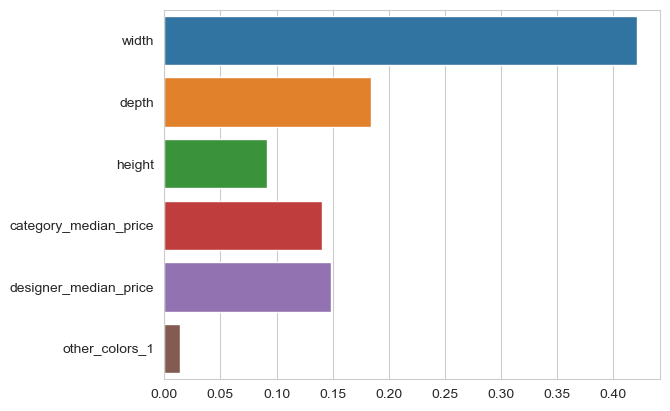

In [ ]:
from sklearn.model_selection import GridSearchCV

X_train, X_test, Y_train, Y_test = sk.model_selection.train_test_split(X2, Y2, test_size=0.2, random_state=42)
forest_grid = GridSearchCV(RandomForestRegressor(), {'n_estimators': [10,50,100,110,120,130, 140,150,200,500], 
                                                     'max_depth': [10,100,200,None], 
                                                     'max_features': ['auto','sqrt','log2']}, cv=5, n_jobs=-1, verbose=3)
forest_grid.fit(X_train, Y_train)

print('Best Estimator :',forest_grid.best_estimator_)
print('Best Score     :',forest_grid.best_score_)
print('')
print('R^2            : {:.5f}'.format(sk.metrics.r2_score(Y_test, forest_grid.predict(X_test))))
print('MAE            : {:.5f}'.format(sk.metrics.mean_absolute_error(forest_grid.predict(X_test), Y_test)))
print('RMSE           : {:.5f}'.format(np.sqrt(sk.metrics.mean_squared_error(forest_grid.predict(X_test), Y_test))))
print('')
print('Feature importance:')
print('--------------------------------')
for feat, importance in zip(X_train.columns, forest_grid.best_estimator_.feature_importances_):
    print('{:.5f}    {f}'.format(importance, f=feat))

sns.set_style('whitegrid')
sns.barplot(y=X_train.columns, x=forest_grid.best_estimator_.feature_importances_)

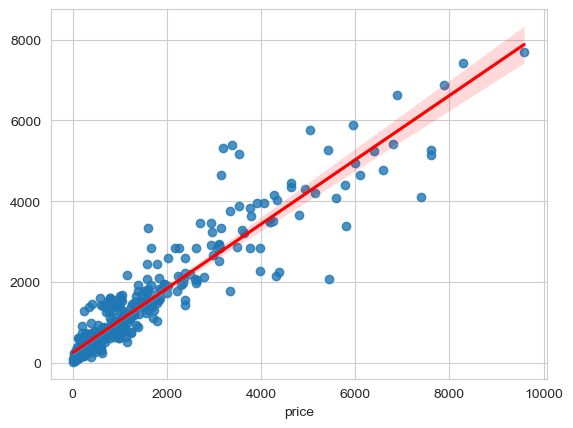

In [ ]:
sns.regplot(x=Y_test, y=forest_grid.predict(X_test),line_kws={'color':'red'})
plt.show()

### Предложите методы повышения производительности модели. Опишите результаты.

Для улучшения качества модели необходимо улучшать качество данных.

Можно попробовать извлечь недостающие габариты из описания товара. 

Как видно из таблицы и графика важности переменных (feature importance) "дизайнеры" вносят довольно большой вклад. 
Мы провели тест с кодированием дизайнеров, но результат аналогичен результату теста 3. 

Необходимо попробовать извлечь габариты из описания и с кодированными дизайнерами провести заново тесты


--------
В данном проекте мы оценили и изучили предоставленный набор данных, проверили гипотезы о распределениях параметров. Построили модель предсказания цен на мебель. В процессе обучения модели протестировали несколько стратегий заполнения недостающих данных, подобрали наилучший регрессор и его оптимальные параметры.